In [1]:
import copy
import functools
import itertools as it
import logging
import random
import sys
import typing

from hstrat import _auxiliary_lib as hstrat_aux
import interval_search as inch
from IPython.core.display import display, HTML
from matplotlib import pyplot as plt
from nbmetalog import nbmetalog as nbm
import numpy as np
import opytional as opyt
import pandas as pd
import pytest
from scipy import stats as scipy_stats
import seaborn as sns
from tqdm import tqdm

import pylib

random.seed(1)

logging.basicConfig(
    format="[%(funcName)s:%(lineno)d] %(message)s",
)
logger = logging.getLogger()

pylib.jupyter_hide_toggle(hide=True)


<IPython.core.display.Javascript object>

In [2]:
nbm.print_metadata()

pylib.jupyter_hide_toggle(hide=True)


context: ci
hostname: fv-az570-684
interpreter: 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
nbcellexec: null
nbname: 05-fractional-incrementing-incidence-reservation-surface-with-safety-aligned-transition
nbpath: /home/runner/work/hstrat-surface-concept/hstrat-surface-concept/binder/05-fractional-incrementing-incidence-reservation-surface-with-safety-aligned-transition.ipynb
revision: null
session: d7fd5630-2797-497f-985a-cc097c3c0119
timestamp: 2024-02-12T04:49:05Z00:00


IPython==7.31.1
keyname==0.5.2
yaml==6.0
hstrat==1.7.4
interval_search==0.5.2
logging==0.5.1.2
matplotlib==3.6.2
nbmetalog==0.2.6
numpy==1.23.5
opytional==0.1.0
pandas==1.5.2
pytest==7.2.2
scipy==1.10.1
seaborn==0.12.1
re==2.2.1
comm==0.1.3
psutil==5.9.5
zmq==25.1.0
json==2.0.9
ipykernel==6.23.3


<IPython.core.display.Javascript object>

# Section 1: Implement `get_deposition_site_at_rank`


## Section 1a: Prepare Support


In [3]:
def get_num_sites_reserved_per_incidence_at_rank(rank: int) -> int:
    return pylib.bit_ceil(
        pylib.hanoi.get_max_hanoi_value_through_index(rank) + 1
    )


In [4]:
# test get_num_sites_reserved_per_incidence_at_rank
assert [
    get_num_sites_reserved_per_incidence_at_rank(rank) for rank in range(17)
] == [
    # hanoi sequence (1-based):
    1,  # 1,
    2,  # 2,
    2,  # 1,
    4,  # 3,
    4,  # 1,
    4,  # 2,
    4,  # 1,
    4,  # 4,
    4,  # 1,
    4,  # 2,
    4,  # 1,
    4,  # 3,
    4,  # 1,
    4,  # 2,
    4,  # 1,
    8,  # 5,
    8,  # 1,
]
pylib.jupyter_hide_toggle(hide=True)


<IPython.core.display.Javascript object>

In [5]:
@pylib.log_args_and_result(logger, logging.DEBUG)
def get_num_incidence_reservations_at_rank(
    rank: int, surface_size: int
) -> int:
    reservation_size = get_num_sites_reserved_per_incidence_at_rank(rank)
    assert surface_size % reservation_size == 0
    num_reservations = surface_size // reservation_size
    return num_reservations


In [6]:
# test get_num_incidence_reservations_at_rank
assert [
    get_num_incidence_reservations_at_rank(rank, 64) for rank in range(17)
] == [
    # hanoi sequence (1-based):
    64,  # 1,
    32,  # 2,
    32,  # 1,
    16,  # 3,
    16,  # 1,
    16,  # 2,
    16,  # 1,
    16,  # 4,
    16,  # 1,
    16,  # 2,
    16,  # 1,
    16,  # 3,
    16,  # 1,
    16,  # 2,
    16,  # 1,
    8,   # 5,
    8,   # 1,
]

pylib.jupyter_hide_toggle(hide=True)


<IPython.core.display.Javascript object>

In [7]:
def get_surface_rank_capacity(surface_size: int) -> int:
    return pylib.hanoi.get_index_of_hanoi_value_nth_incidence(surface_size, 0)


In [8]:
for surface_size_exp in range(2, 12):
    surface_size = 2**surface_size_exp
    get_num_incidence_reservations_at_rank(
        get_surface_rank_capacity(surface_size) - 1,
        surface_size,
    )
    with pytest.raises(AssertionError):
        get_num_incidence_reservations_at_rank(
            get_surface_rank_capacity(surface_size),
            surface_size,
        )

pylib.jupyter_hide_toggle(hide=True)


<IPython.core.display.Javascript object>

In [9]:
def is_2x_reservation_eligible(
    hanoi_value: int, surface_size: int, rank: int
) -> bool:
    reservation_width = get_num_sites_reserved_per_incidence_at_rank(rank)
    lb_inclusive = (
        pylib.hanoi.get_max_hanoi_value_through_index(rank)
        - reservation_width // 2
        + 1
    )
    ub_exclusive = reservation_width // 2
    return lb_inclusive <= hanoi_value < ub_exclusive


pylib.jupyter_hide_toggle()


In [10]:
def is_hanoi_invader(hanoi_value: int, rank: int) -> bool:
    reservation_width = get_num_sites_reserved_per_incidence_at_rank(rank)
    return hanoi_value >= reservation_width // 2


In [11]:
assert not is_hanoi_invader(
    1, pylib.hanoi.get_index_of_hanoi_value_nth_incidence(2, 0)
)
assert is_hanoi_invader(
    3, pylib.hanoi.get_index_of_hanoi_value_nth_incidence(2, 0)
)

assert not is_hanoi_invader(
    3, pylib.hanoi.get_index_of_hanoi_value_nth_incidence(4, 0)
)

assert not is_hanoi_invader(
    1, pylib.hanoi.get_index_of_hanoi_value_nth_incidence(4, 0)
)

pylib.jupyter_hide_toggle(hide=True)


<IPython.core.display.Javascript object>

In [12]:
def is_hanoi_invaded(hanoi_value: int, rank: int) -> bool:
    reservation_width = get_num_sites_reserved_per_incidence_at_rank(rank)
    max_hanoi_value = pylib.hanoi.get_max_hanoi_value_through_index(rank)

    return (
        not is_hanoi_invader(hanoi_value, rank)
        and max_hanoi_value >= hanoi_value + reservation_width // 2
    )


In [13]:
assert not is_hanoi_invaded(
    1, pylib.hanoi.get_index_of_hanoi_value_nth_incidence(2, 0)
)
assert is_hanoi_invaded(
    0, pylib.hanoi.get_index_of_hanoi_value_nth_incidence(2, 0)
)
assert not is_hanoi_invaded(
    3, pylib.hanoi.get_index_of_hanoi_value_nth_incidence(2, 0)
)

assert not is_hanoi_invaded(
    3, pylib.hanoi.get_index_of_hanoi_value_nth_incidence(4, 0)
)
assert is_hanoi_invaded(
    0, pylib.hanoi.get_index_of_hanoi_value_nth_incidence(4, 0)
)
assert not is_hanoi_invaded(
    1, pylib.hanoi.get_index_of_hanoi_value_nth_incidence(4, 0)
)
assert is_hanoi_invaded(
    1, pylib.hanoi.get_index_of_hanoi_value_nth_incidence(5, 0)
)

pylib.jupyter_hide_toggle(hide=True)


<IPython.core.display.Javascript object>

In [14]:
def is_hanoi_invadable_and_uninvaded(hanoi_value: int, rank: int) -> bool:
    return not is_hanoi_invader(hanoi_value, rank) and not is_hanoi_invaded(
        hanoi_value, rank
    )


In [15]:
assert is_hanoi_invadable_and_uninvaded(
    1, pylib.hanoi.get_index_of_hanoi_value_nth_incidence(2, 0)
)
assert not is_hanoi_invadable_and_uninvaded(
    2, pylib.hanoi.get_index_of_hanoi_value_nth_incidence(2, 0)
)
assert not is_hanoi_invadable_and_uninvaded(
    0, pylib.hanoi.get_index_of_hanoi_value_nth_incidence(2, 0)
)
assert not is_hanoi_invadable_and_uninvaded(
    3, pylib.hanoi.get_index_of_hanoi_value_nth_incidence(2, 0)
)
assert is_hanoi_invadable_and_uninvaded(
    3, pylib.hanoi.get_index_of_hanoi_value_nth_incidence(4, 0)
)
assert not is_hanoi_invadable_and_uninvaded(
    0, pylib.hanoi.get_index_of_hanoi_value_nth_incidence(4, 0)
)
assert is_hanoi_invadable_and_uninvaded(
    1, pylib.hanoi.get_index_of_hanoi_value_nth_incidence(4, 0)
)
assert not is_hanoi_invadable_and_uninvaded(
    1, pylib.hanoi.get_index_of_hanoi_value_nth_incidence(5, 0)
)
assert not is_hanoi_invadable_and_uninvaded(
    5, pylib.hanoi.get_index_of_hanoi_value_nth_incidence(5, 0)
)
pylib.jupyter_hide_toggle(hide=True)


<IPython.core.display.Javascript object>

In [16]:
def iter_hanoi_invader_values(hanoi_value: int) -> typing.Iterator[int]:
    for i in it.count():
        yield hanoi_value + pylib.bit_ceil(hanoi_value + 1) * 2**i


In [17]:
assert [*it.islice(iter_hanoi_invader_values(0), 6)] == [1, 2, 4, 8, 16, 32]
assert [*it.islice(iter_hanoi_invader_values(3), 4)] == [7, 11, 19, 35]
assert [*it.islice(iter_hanoi_invader_values(8), 2)] == [24, 40]

pylib.jupyter_hide_toggle(hide=True)


<IPython.core.display.Javascript object>

In [18]:
def has_hanoi_value_filled_first_reservation_layer(
    hanoi_value: int, surface_size: int, rank: int
):
    first_instance_index = pylib.hanoi.get_index_of_hanoi_value_nth_incidence(
        hanoi_value, 0
    )
    if first_instance_index >= get_surface_rank_capacity(surface_size):
        return False

    first_layer_size = get_num_incidence_reservations_at_rank(
        pylib.hanoi.get_index_of_hanoi_value_nth_incidence(hanoi_value, 0),
        surface_size,
    )
    return not (
        pylib.hanoi.get_incidence_count_of_hanoi_value_through_index(
            hanoi_value,
            rank,
        )
        < first_layer_size
    )


In [19]:
def get_upcoming_hanoi_invasion_value(hanoi_value: int, rank: int) -> int:
    rank = max(
        rank,
        pylib.hanoi.get_index_of_hanoi_value_nth_incidence(hanoi_value, 0),
    )

    reservation_width = get_num_sites_reserved_per_incidence_at_rank(rank)
    if is_hanoi_invader(hanoi_value, rank) or is_hanoi_invaded(
        hanoi_value, rank
    ):
        return hanoi_value + reservation_width
    else:
        return hanoi_value + reservation_width // 2


In [20]:
def get_upcoming_hanoi_invasion_rank(hanoi_value: int, rank: int) -> int:
    upcoming_invasion_hanoi_value = get_upcoming_hanoi_invasion_value(
        hanoi_value, rank
    )
    upcoming_invasion_rank = (
        pylib.hanoi.get_index_of_hanoi_value_nth_incidence(
            upcoming_invasion_hanoi_value, 0
        )
    )
    return upcoming_invasion_rank


In [21]:
def get_regime_mx(hanoi_value: int, rank: int) -> int:
    if is_hanoi_invadable_and_uninvaded(hanoi_value, rank):
        return 2
    else:
        return 1


In [22]:
def get_regime_num_reservations_available(
    hanoi_value: int, surface_size: int, rank: int
) -> int:
    mx = get_regime_mx(hanoi_value, rank)
    return get_num_incidence_reservations_at_rank(rank, surface_size) * mx


In [23]:
def get_safe_downgrade_rank(
    cycle_num_ranks: int,
    required_cycle_rank_position: int,
    required_lag: int,
    end_rank: int,
    hanoi_offset: int,
    cadence_for_asserts: int,
    hanoi_value_for_asserts: int,
):

    offset = hanoi_offset
    hanoi_value = hanoi_value_for_asserts

    assert cadence_for_asserts
    cadence = cadence_for_asserts

    assert cycle_num_ranks
    assert required_cycle_rank_position < cycle_num_ranks
    assert required_lag % cadence == 0
    # oc is offset corrected
    end_rank_oc = end_rank - offset

    deadline_rank_oc = end_rank_oc - required_lag
    #
    #    tt_below |             | goal
    #########################################################
    #             |----tour time----|
    #             |             :   |
    #                                           ^ end_rank
    #                              ^deadline rank
    #               ^mapped to here (intermediate)
    #             ^ then to here
    #                            ^ then to here
    #
    #########################################################
    #             |----tour time----|
    #             |             :   |          :  |
    #                                                    ^ end_rank
    #                                         ^deadline rank
    #                              ^mapped to here (intermediate)
    #             ^ then to here
    #                           ^ then to here
    #
    intermediate_oc = deadline_rank_oc - required_cycle_rank_position
    assert deadline_rank_oc - intermediate_oc <= cycle_num_ranks

    tt_below_oc = intermediate_oc - pylib.modulo(
        intermediate_oc, cycle_num_ranks
    )
    assert tt_below_oc % cadence == 0
    assert tt_below_oc % cycle_num_ranks == 0
    assert (
        deadline_rank_oc - tt_below_oc
        <= cycle_num_ranks + required_cycle_rank_position
    )

    goal_oc = tt_below_oc + required_cycle_rank_position
    assert goal_oc % cycle_num_ranks == required_cycle_rank_position
    assert goal_oc % cadence == 0
    assert goal_oc <= deadline_rank_oc
    assert goal_oc - deadline_rank_oc <= cycle_num_ranks

    downgrade_rank_oc = goal_oc
    downgrade_rank = goal_oc + offset
    assert downgrade_rank <= end_rank
    assert (
        required_lag
        <= end_rank - downgrade_rank
        <= cycle_num_ranks + required_lag
    )

    assert cycle_num_ranks % cadence == 0
    assert (
        pylib.hanoi.get_incidence_count_of_hanoi_value_through_index(
            hanoi_value, offset
        )
    ) % cycle_num_ranks == 1
    assert (
        pylib.hanoi.get_incidence_count_of_hanoi_value_through_index(
            hanoi_value, offset + cadence
        )
    ) % cycle_num_ranks == 2

    assert cycle_num_ranks % cadence == 0
    if tt_below_oc + offset >= 0:
        assert tt_below_oc % cadence == 0
        assert tt_below_oc % cycle_num_ranks == 0
        assert (
            pylib.hanoi.get_incidence_count_of_hanoi_value_through_index(
                hanoi_value, tt_below_oc + offset
            )
            - 1
        ) % (cycle_num_ranks // cadence) == 0
    if downgrade_rank >= 0:
        assert (downgrade_rank + cadence - offset) % cadence == 0
        assert (
            pylib.hanoi.get_incidence_count_of_hanoi_value_through_index(
                hanoi_value, downgrade_rank
            )
            - 1
        ) % (cycle_num_ranks // cadence) == (
            required_cycle_rank_position // cadence
        )

    return downgrade_rank


In [24]:
def get_regime_reservation_downgrade_rank(
    hanoi_value: int, surface_size: int, rank: int
) -> int:
    cadence = pylib.hanoi.get_hanoi_value_index_cadence(hanoi_value)
    offset = pylib.hanoi.get_hanoi_value_index_offset(hanoi_value)
    big_tour_size = get_regime_num_reservations_available(
        hanoi_value,
        surface_size,
        rank,
    )
    if big_tour_size == 1:
        return sys.maxsize
    big_tour_time = big_tour_size * cadence
    end_rank = get_upcoming_hanoi_invasion_rank(hanoi_value, rank)
    assert end_rank

    cycle_num_ranks = big_tour_time
    required_cycle_rank_position = big_tour_time // 2 - cadence
    assert required_cycle_rank_position % cadence == 0
    assert required_cycle_rank_position < cycle_num_ranks
    required_lag = big_tour_time // 2
    assert required_lag % cadence == 0

    downgrade_rank = get_safe_downgrade_rank(
        cycle_num_ranks=cycle_num_ranks,
        required_cycle_rank_position=required_cycle_rank_position,
        required_lag=required_lag,
        end_rank=end_rank,
        hanoi_offset=offset,
        cadence_for_asserts=cadence,
        hanoi_value_for_asserts=hanoi_value,
    )
    assert downgrade_rank <= end_rank
    return downgrade_rank


In [25]:
def get_fractional_downgrade_state(
    hanoi_value: int, surface_size: int, rank: int
) -> typing.Dict:
    for invading_hanoi_value in iter_hanoi_invader_values(hanoi_value):
        if invading_hanoi_value >= 2**surface_size // 2:
            return None
        if not has_hanoi_value_filled_first_reservation_layer(
            invading_hanoi_value, surface_size, rank
        ):
            break

    assert invading_hanoi_value > hanoi_value

    for attempt in 1, 2:
        invader_cadence = pylib.hanoi.get_hanoi_value_index_cadence(
            invading_hanoi_value
        )
        protagonist_cadence = pylib.hanoi.get_hanoi_value_index_cadence(
            hanoi_value
        )

        if invading_hanoi_value > surface_size // 2:
            return None

        invasion_rank = pylib.hanoi.get_index_of_hanoi_value_nth_incidence(
            invading_hanoi_value, 0
        )
        num_reservations = get_num_incidence_reservations_at_rank(
            invasion_rank, surface_size
        )
        if num_reservations == 1:
            return None

        tour_size = 2 * num_reservations

        protagonist_tour_time = tour_size * protagonist_cadence
        num_protagonist_cycles_per_invader_cadence = (
            invader_cadence // protagonist_tour_time
        )
        if num_protagonist_cycles_per_invader_cadence >= (
            # see test_calc_dyadic_lcm_upper_bound.py
            # https://github.com/mmore500/hstrat-surface-concept/blob/4d0eca2ae3fe1890983889fdb8a8482fd3b24627/pylib/test/test_calc_dyadic_lcm_upper_bound.py#L39
            4
            * tour_size
        ):
            break

        if attempt == 1 and invasion_rank <= rank:
            invading_hanoi_value = (
                hanoi_value + (invading_hanoi_value - hanoi_value) * 2
            )
    else:
        return None

    # see test_calc_dyadic_lcm_upper_bound.py
    # https://github.com/mmore500/hstrat-surface-concept/blob/4d0eca2ae3fe1890983889fdb8a8482fd3b24627/pylib/test/test_calc_dyadic_lcm_upper_bound.py#L39
    # num_granules * tour_size * 2 == num_protagonist_cycles_per_invader_cadence
    # num_granules == num_protagonist_cycles_per_invader_cadence // (tour_size * 2)
    num_granules = min(
        num_protagonist_cycles_per_invader_cadence // (tour_size * 2),
        num_reservations,
    )
    assert 1 < num_granules <= num_reservations, (
        num_granules,
        num_reservations,
    )
    granule_size = num_reservations // num_granules
    assert granule_size

    raw_current_subtrahend = (
        pylib.hanoi.get_incidence_count_of_hanoi_value_through_index(
            invading_hanoi_value,
            rank,
        )
    )
    raw_next_subtrahend = raw_current_subtrahend + 1

    current_subtrahend_granule = (
        raw_current_subtrahend + granule_size - 1
    ) // granule_size
    assert current_subtrahend_granule <= raw_current_subtrahend
    assert bool(current_subtrahend_granule) == bool(raw_current_subtrahend)

    next_subtrahend_granule = (
        raw_next_subtrahend + granule_size - 1
    ) // granule_size
    assert next_subtrahend_granule <= raw_next_subtrahend
    assert bool(next_subtrahend_granule) == bool(raw_next_subtrahend)

    granularized_current_subtrahend = current_subtrahend_granule * granule_size
    assert granularized_current_subtrahend >= raw_current_subtrahend

    granularized_next_subtrahend = next_subtrahend_granule * granule_size
    assert granularized_next_subtrahend >= raw_next_subtrahend

    assert (
        0
        <= granularized_current_subtrahend
        <= granularized_next_subtrahend
        <= num_reservations
    )

    upcoming_invader_rank = (
        pylib.hanoi.get_index_of_hanoi_value_next_incidence(
            invading_hanoi_value, rank
        )
    )
    assert upcoming_invader_rank > rank
    return {
        "hanoi value": hanoi_value,
        "hanoi cadence": protagonist_cadence,
        "upcoming invader rank": upcoming_invader_rank,
        "first invasion rank": invasion_rank,
        "invader cadence": invader_cadence,
        "invading hanoi value": invading_hanoi_value,
        "current subtrahend": granularized_current_subtrahend,
        "next subtrahend": granularized_next_subtrahend,
        "tour size": tour_size,
        "num granules": num_granules,
        "granule size": granule_size,
    }


In [26]:
def get_fractional_downgrade_rank(
    hanoi_value: int,
    surface_size: int,
    rank: int,
    fractional_downgrade_state: typing.Dict,
) -> int:
    state = fractional_downgrade_state

    cadence = pylib.hanoi.get_hanoi_value_index_cadence(hanoi_value)
    offset = pylib.hanoi.get_hanoi_value_index_offset(hanoi_value)
    big_tour_size = pylib.calc_dyadic_lcm_upper_bound(
        state["tour size"] - state["current subtrahend"],
        state["tour size"] - state["next subtrahend"],
    )

    if state["tour size"] == 1:
        return sys.maxsize
    big_tour_time = big_tour_size * cadence
    end_rank = state["upcoming invader rank"]
    assert end_rank

    cycle_num_ranks = big_tour_time
    required_cycle_rank_position = 0

    assert required_cycle_rank_position % cadence == 0
    assert required_cycle_rank_position < cycle_num_ranks
    required_lag = (state["tour size"] - state["next subtrahend"]) * cadence
    assert required_lag % cadence == 0
    res = get_safe_downgrade_rank(
        cycle_num_ranks=cycle_num_ranks,
        required_cycle_rank_position=required_cycle_rank_position,
        required_lag=required_lag,
        end_rank=end_rank,
        hanoi_offset=offset,
        cadence_for_asserts=cadence,
        hanoi_value_for_asserts=hanoi_value,
    )

    assert res > state["upcoming invader rank"] - state["invader cadence"]
    assert res <= state["upcoming invader rank"]
    assert res > 0
    return res


In [27]:
def get_fractional_downgrade_num_reservations_provided(
    hanoi_value: int,
    surface_size: int,
    rank: int,
    fractional_downgrade_state: typing.Dict,
) -> int:
    thresh = get_fractional_downgrade_rank(
        hanoi_value,
        surface_size,
        rank,
        fractional_downgrade_state,
    )

    state = fractional_downgrade_state
    if rank >= thresh:
        return state["tour size"] - state["next subtrahend"]
    else:
        return state["tour size"] - state["current subtrahend"]


In [28]:
def get_regime_num_reservations_provided(
    hanoi_value: int, surface_size: int, rank: int
) -> int:
    thresh = get_regime_reservation_downgrade_rank(
        hanoi_value, surface_size, rank
    )
    before_thresh_num = get_regime_num_reservations_available(
        hanoi_value,
        surface_size,
        rank,
    )
    if rank >= thresh:
        return before_thresh_num // 2
    else:
        return before_thresh_num


In [29]:
@functools.lru_cache(maxsize=8192)
def get_num_reservations_provided(
    hanoi_value: int, surface_size: int, rank: int
) -> int:
    fractional_downgrade_state = get_fractional_downgrade_state(
        hanoi_value, surface_size, rank
    )
    if fractional_downgrade_state is not None:
        return get_fractional_downgrade_num_reservations_provided(
            hanoi_value,
            surface_size,
            rank,
            fractional_downgrade_state,
        )
    else:
        return get_regime_num_reservations_provided(
            hanoi_value, surface_size, rank
        )


## Section 1b: Define `get_deposition_site_at_rank`


In [30]:
def get_deposition_site_at_rank(rank: int, surface_size: int) -> int:
    if rank > get_surface_rank_capacity(surface_size):
        raise ValueError(
            f"{surface_size}-bit surface only valid "
            "through rank <= {get_surface_rank_capacity(surface_size)}, "
            f"rank {rank} was requested"
        )

    within_reservation_offset = pylib.hanoi.get_hanoi_value_at_index(rank)

    num_incidence_reservations = get_num_reservations_provided(
        within_reservation_offset, surface_size, rank
    )

    reservation_index = (
        pylib.hanoi.get_hanoi_value_incidence_at_index(rank)
        % num_incidence_reservations
    )

    longevity_ordered_reservation_position = (
        # this is more correct in a theoretical sense, and does have some effect
        # but actual functional improvements relative to simpler naive/alternating
        # should be tested; it may not be worth the extra complexity
        pylib.longevity_ordering_descending.get_longevity_mapped_position_of_index(
            reservation_index,
            surface_size,
        )
    )
    if reservation_index == 0:
        assert longevity_ordered_reservation_position == 0
    elif reservation_index == pylib.bit_ceil(num_incidence_reservations) - 1:
        assert longevity_ordered_reservation_position == (
            surface_size // pylib.bit_ceil(num_incidence_reservations)
        )

    res = (
        longevity_ordered_reservation_position
        + within_reservation_offset
    )
    if rank == 0:
        assert res == 0, {
            "longevity_ordered_reservation_position": longevity_ordered_reservation_position,
            "reservation_index": reservation_index,
            "surface_size": surface_size,
            "within_reservation_offset": within_reservation_offset,
        }
    assert res < surface_size
    return res


# Section 2: evaluate `get_deposition_site_at_rank`


## Section 2a: Unit Test


In [31]:
# test get_deposition_site_at_rank
# **needs to be updated**
# assert [get_deposition_site_at_rank(rank, 64) for rank in range(23)] == [
#          # num_reservations
#          #     # hanoi sequence (0-based):
#     0,   # 64, # 0,
#     1,   # 32, # 1,
#     32,  # 32, # 0,
#     2,   # 16, # 2,
#     16,  # 16, # 0,
#     33,  # 16, # 1,
#     48,  # 16, # 0,
#     3,   # 16, # 3,
#     8,   # 16, # 0,
#     17,  # 16, # 1,
#     24,  # 16, # 0,
#     34,  # 16, # 2,
#     40,  # 16, # 0,
#     49,  # 16, # 1,
#     56,  # 16, # 0,
#     4,   # 8,  # 4,
#     0,   # 8,  # 0,
#     9,   # 8,  # 1,
#     32,  # 8,  # 0,
#     18,  # 8,  # 2,
#     16,  # 8,  # 0,
#     25,  # 8,  # 1,
#     48,  # 8,  # 0,
# ]

# assert [get_deposition_site_at_rank(rank, 16) for rank in range(21)] == [
#         # num_reservations
#         #     # hanoi sequence (0-based):
#     0,  # 16, # 0,
#     1,  # 8,  # 1,
#     8,  # 8,  # 0,
#     2,  # 4,  # 2,
#     4,  # 4,  # 0,
#     9,  # 4,  # 1,
#     12, # 4,  # 0,
#     3,  # 4,  # 3,
#     0,  # 4,  # 0,
#     5,  # 4,  # 1,
#     8,  # 4,  # 0,
#     10, # 4,  # 2,
#     4,  # 4,  # 0,
#     13, # 4,  # 1,
#     12, # 4,  # 0,
#     4,  # 2,  # 4,
#     0,  # 2,  # 0,
#     1,  # 2,  # 1,
#     8,  # 2,  # 0,
#     6,  # 2,  # 2,
#     0,  # 2,  # 0,
# ]

pylib.jupyter_hide_toggle(hide=True)


<IPython.core.display.Javascript object>

## Section 2a: Integration Test


In [32]:
for surface_size_exp in range(3, 10, 2):
    surface_size = 2**surface_size_exp
    res = (
        pylib.site_selection_eval.get_first_decreasing_hanoi_value_deposition(
            get_deposition_site_at_rank,
            surface_size=surface_size,
            num_generations=min(
                2**18, get_surface_rank_capacity(surface_size) - 1
            ),
            progress_wrap=tqdm,
        )
    )
    assert res is None, res

    res = pylib.site_selection_eval.get_first_deposition_over_too_new_site(
        get_deposition_site_at_rank,
        get_num_reservations_provided,
        pylib.longevity_ordering_descending.get_longevity_mapped_position_of_index,
        surface_size=surface_size,
        num_generations=min(
            2**18, get_surface_rank_capacity(surface_size) - 1
        ),
        progress_wrap=tqdm,
    )
    assert res is None, res


100%|██████████| 262144/262144 [00:27<00:00, 9391.51it/s]


## Section 2b: Visualize


100%|██████████| 127/127 [00:00<00:00, 26668.50it/s]


teeplots/05/num-generations=127+surface-size=8+viz=site-differentia-by-rank-heatmap+ynorm=log+ext=.pdf
teeplots/05/num-generations=127+surface-size=8+viz=site-differentia-by-rank-heatmap+ynorm=log+ext=.png


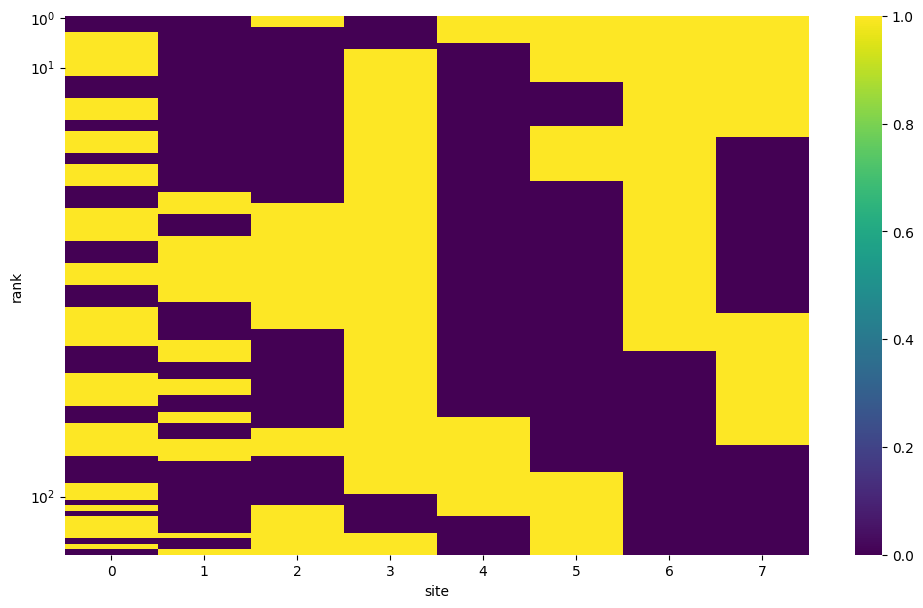

teeplots/05/num-generations=127+surface-size=8+viz=site-differentia-by-rank-heatmap+ynorm=linear+ext=.pdf
teeplots/05/num-generations=127+surface-size=8+viz=site-differentia-by-rank-heatmap+ynorm=linear+ext=.png


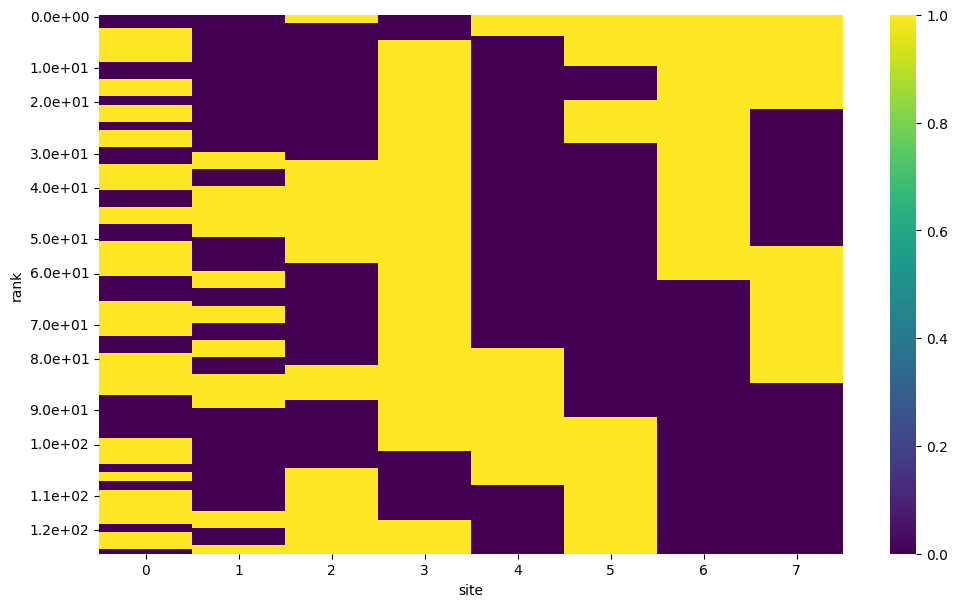

teeplots/05/cnorm=log+num-generations=127+surface-size=8+viz=site-deposition-rank-by-rank-heatmap+ynorm=log+ext=.pdf
teeplots/05/cnorm=log+num-generations=127+surface-size=8+viz=site-deposition-rank-by-rank-heatmap+ynorm=log+ext=.png


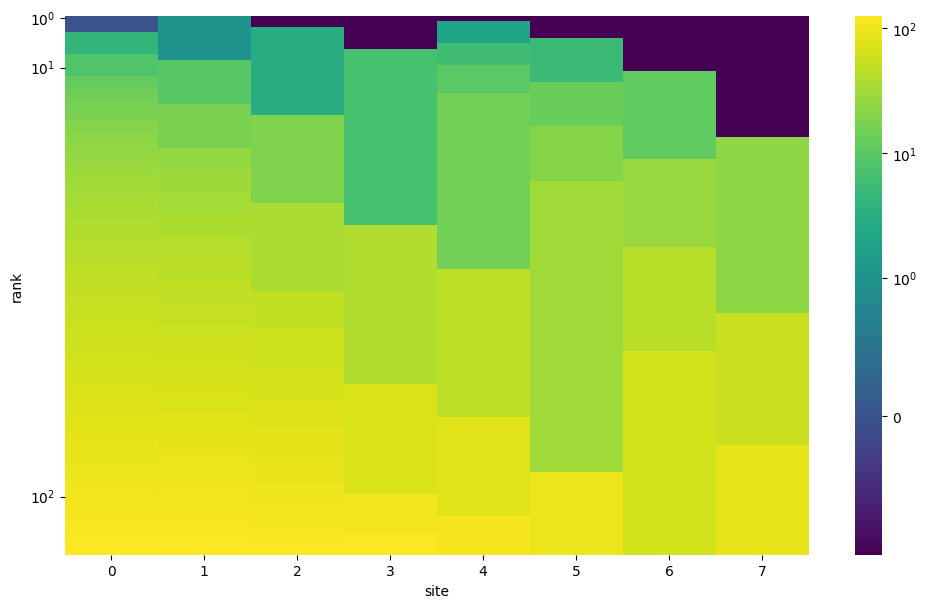

teeplots/05/cnorm=None+num-generations=127+surface-size=8+viz=site-deposition-rank-by-rank-heatmap+ynorm=linear+ext=.pdf
teeplots/05/cnorm=None+num-generations=127+surface-size=8+viz=site-deposition-rank-by-rank-heatmap+ynorm=linear+ext=.png


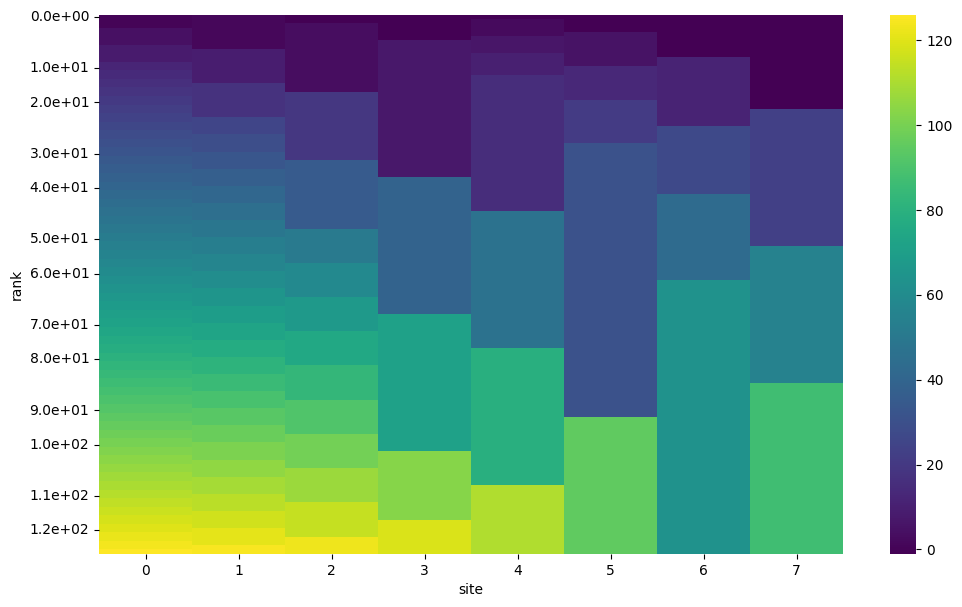

teeplots/05/num-generations=127+surface-size=8+viz=site-hanoi-value-by-rank-heatmap+ext=.pdf
teeplots/05/num-generations=127+surface-size=8+viz=site-hanoi-value-by-rank-heatmap+ext=.png


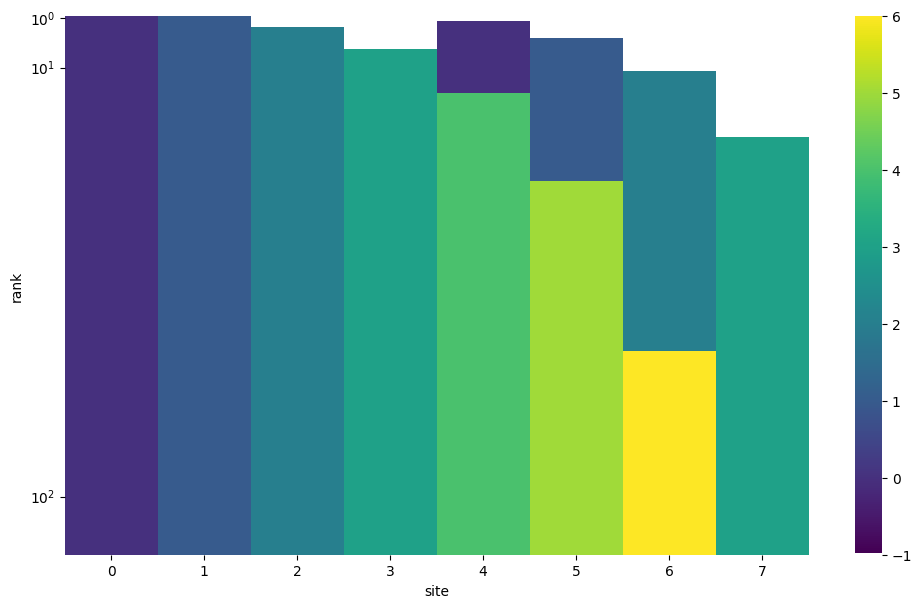

teeplots/05/num-generations=127+surface-size=8+viz=site-hanoi-value-by-rank-heatmap+ynorm=linear+ext=.pdf
teeplots/05/num-generations=127+surface-size=8+viz=site-hanoi-value-by-rank-heatmap+ynorm=linear+ext=.png


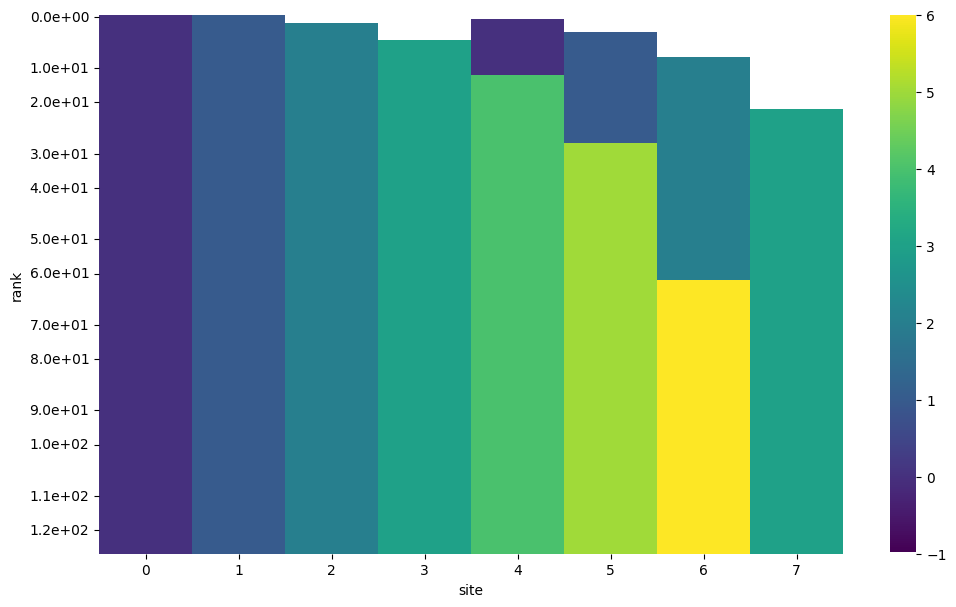

teeplots/05/cnorm=log+num-generations=127+surface-size=8+viz=site-deposition-depth-by-rank-heatmap+ynorm=log+ext=.pdf
teeplots/05/cnorm=log+num-generations=127+surface-size=8+viz=site-deposition-depth-by-rank-heatmap+ynorm=log+ext=.png


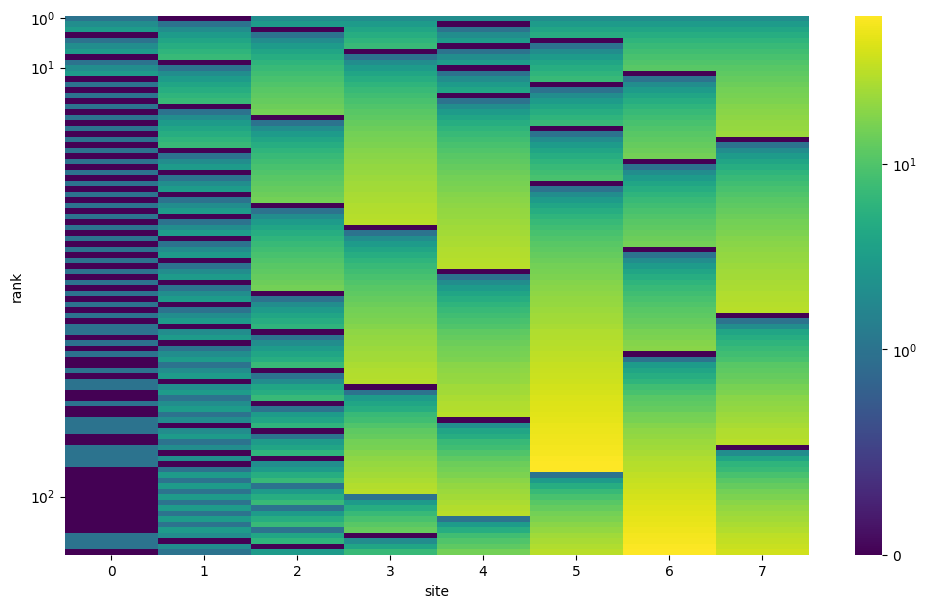

teeplots/05/cnorm=log+num-generations=127+surface-size=8+viz=site-deposition-depth-by-rank-heatmap+ynorm=linear+ext=.pdf
teeplots/05/cnorm=log+num-generations=127+surface-size=8+viz=site-deposition-depth-by-rank-heatmap+ynorm=linear+ext=.png


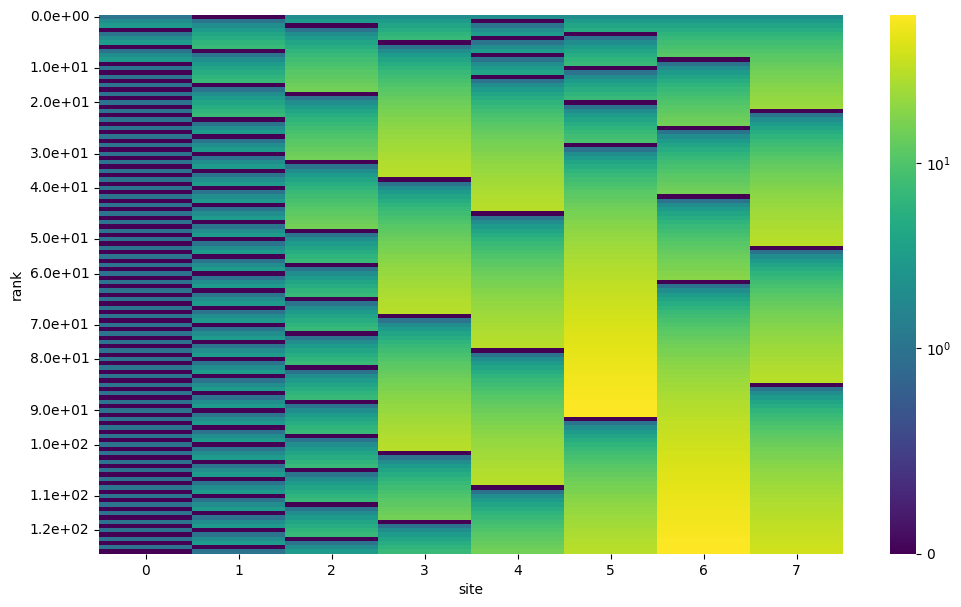

100%|██████████| 125/125 [00:00<00:00, 436.15it/s]


teeplots/05/num-generations=127+surface-size=8+viz=stratum-persistence-dripplot+ext=.pdf
teeplots/05/num-generations=127+surface-size=8+viz=stratum-persistence-dripplot+ext=.png


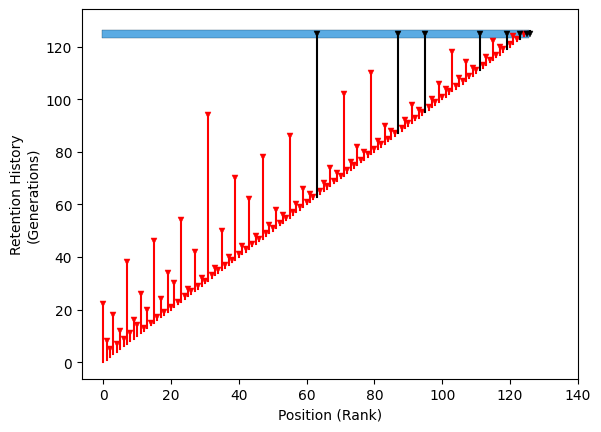

100%|██████████| 262144/262144 [00:16<00:00, 16088.71it/s]


teeplots/05/num-generations=262144+surface-size=32+viz=site-differentia-by-rank-heatmap+ynorm=log+ext=.pdf
teeplots/05/num-generations=262144+surface-size=32+viz=site-differentia-by-rank-heatmap+ynorm=log+ext=.png


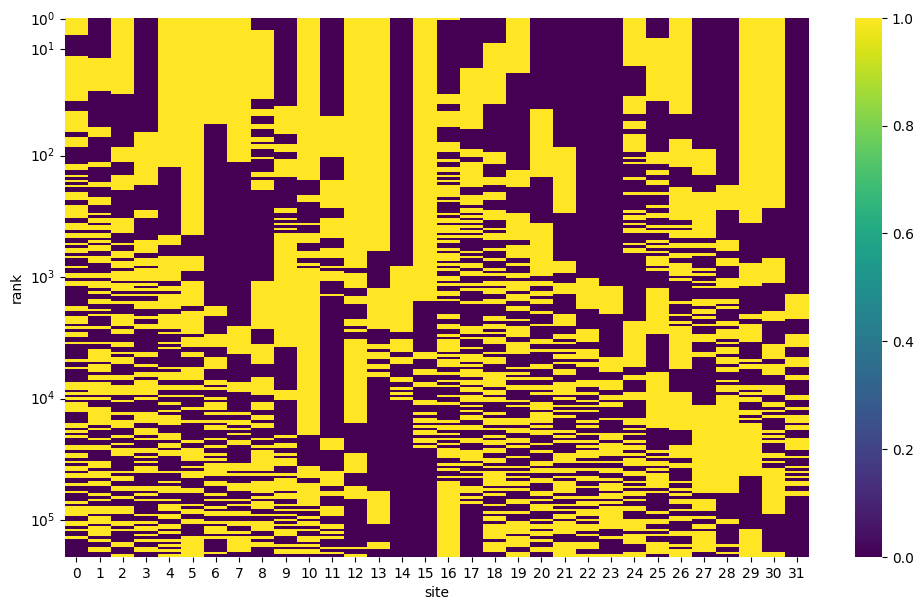

teeplots/05/num-generations=262144+surface-size=32+viz=site-differentia-by-rank-heatmap+ynorm=linear+ext=.pdf
teeplots/05/num-generations=262144+surface-size=32+viz=site-differentia-by-rank-heatmap+ynorm=linear+ext=.png


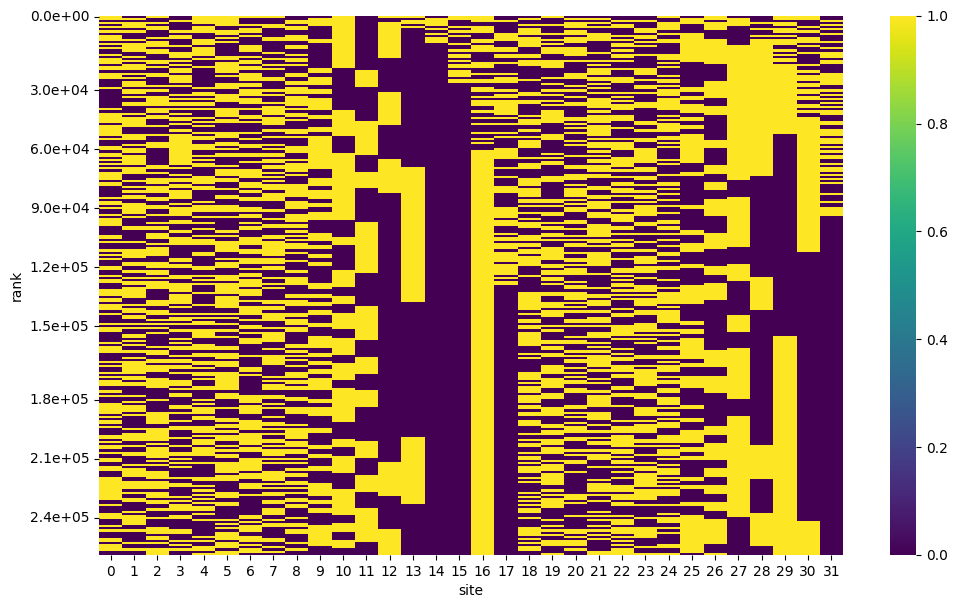

teeplots/05/cnorm=log+num-generations=262144+surface-size=32+viz=site-deposition-rank-by-rank-heatmap+ynorm=log+ext=.pdf
teeplots/05/cnorm=log+num-generations=262144+surface-size=32+viz=site-deposition-rank-by-rank-heatmap+ynorm=log+ext=.png


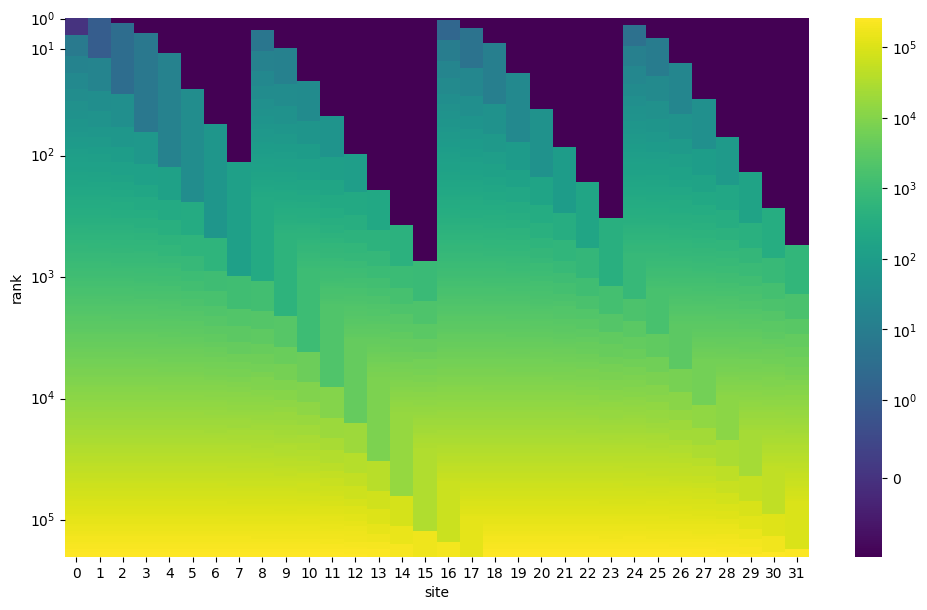

teeplots/05/cnorm=None+num-generations=262144+surface-size=32+viz=site-deposition-rank-by-rank-heatmap+ynorm=linear+ext=.pdf
teeplots/05/cnorm=None+num-generations=262144+surface-size=32+viz=site-deposition-rank-by-rank-heatmap+ynorm=linear+ext=.png


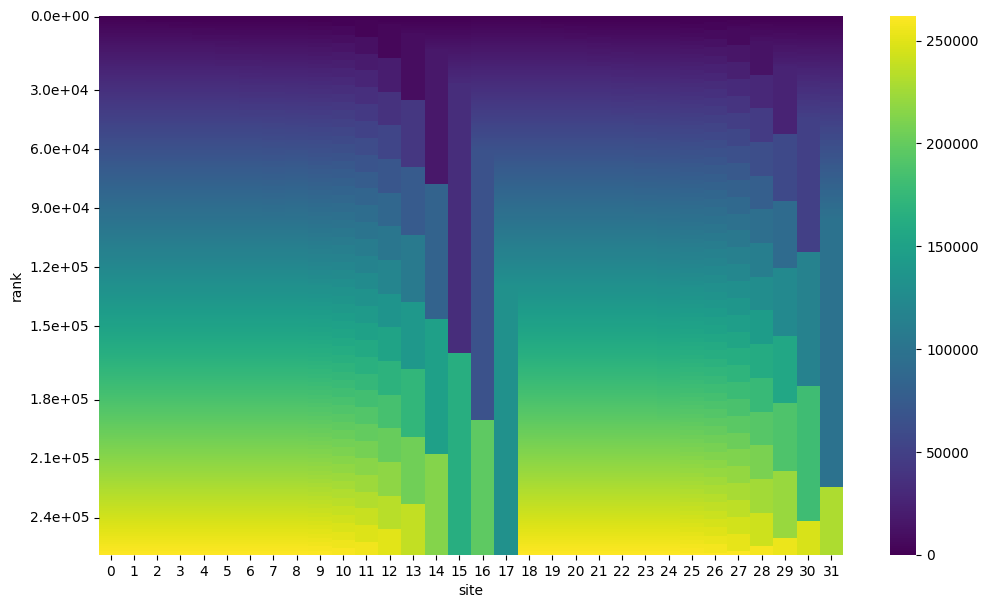

teeplots/05/num-generations=262144+surface-size=32+viz=site-hanoi-value-by-rank-heatmap+ext=.pdf
teeplots/05/num-generations=262144+surface-size=32+viz=site-hanoi-value-by-rank-heatmap+ext=.png


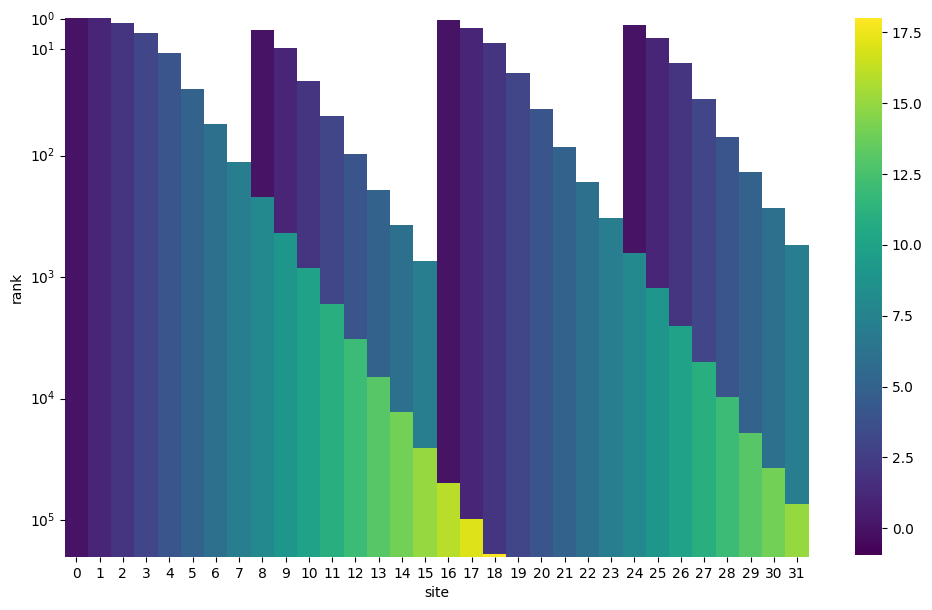

teeplots/05/num-generations=262144+surface-size=32+viz=site-hanoi-value-by-rank-heatmap+ynorm=linear+ext=.pdf
teeplots/05/num-generations=262144+surface-size=32+viz=site-hanoi-value-by-rank-heatmap+ynorm=linear+ext=.png


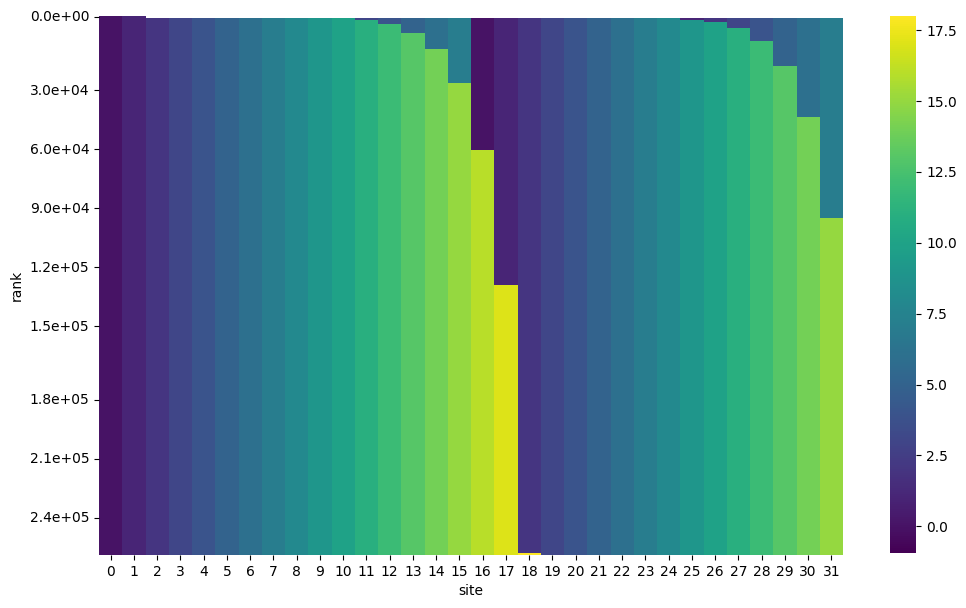

teeplots/05/cnorm=log+num-generations=262144+surface-size=32+viz=site-deposition-depth-by-rank-heatmap+ynorm=log+ext=.pdf
teeplots/05/cnorm=log+num-generations=262144+surface-size=32+viz=site-deposition-depth-by-rank-heatmap+ynorm=log+ext=.png


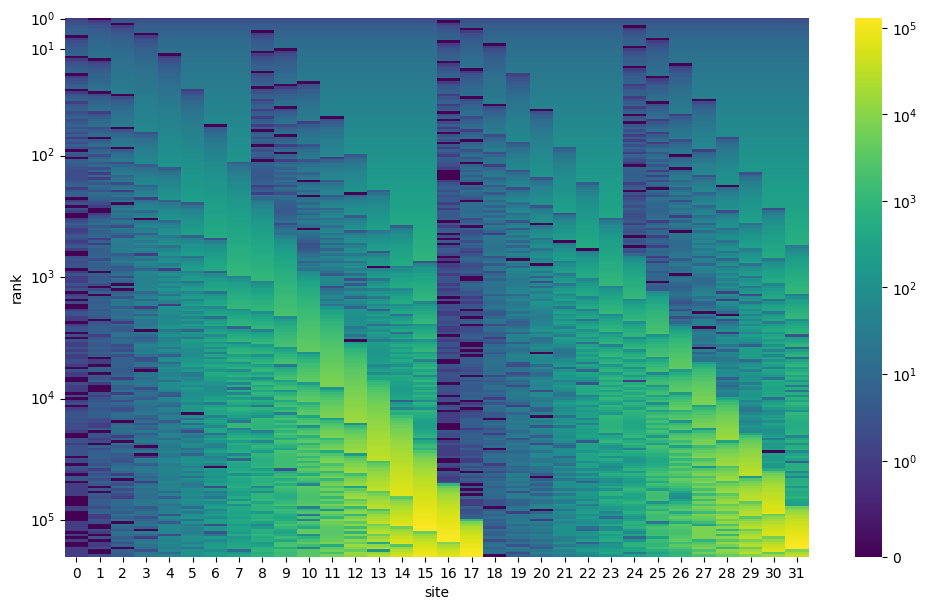

teeplots/05/cnorm=log+num-generations=262144+surface-size=32+viz=site-deposition-depth-by-rank-heatmap+ynorm=linear+ext=.pdf
teeplots/05/cnorm=log+num-generations=262144+surface-size=32+viz=site-deposition-depth-by-rank-heatmap+ynorm=linear+ext=.png


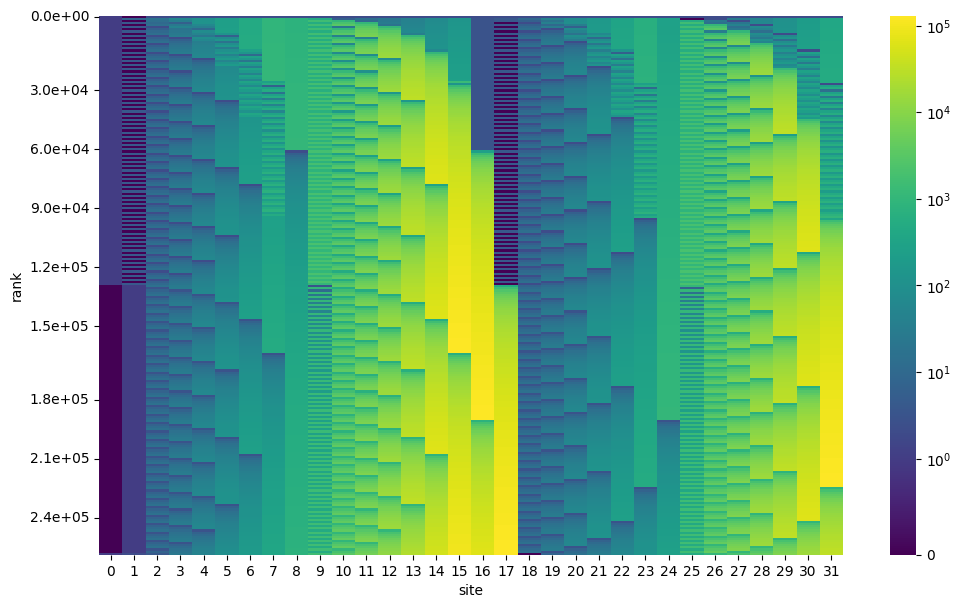

100%|██████████| 2998/2998 [00:08<00:00, 365.83it/s]


teeplots/05/num-generations=262144+surface-size=32+viz=stratum-persistence-dripplot+ext=.pdf
teeplots/05/num-generations=262144+surface-size=32+viz=stratum-persistence-dripplot+ext=.png


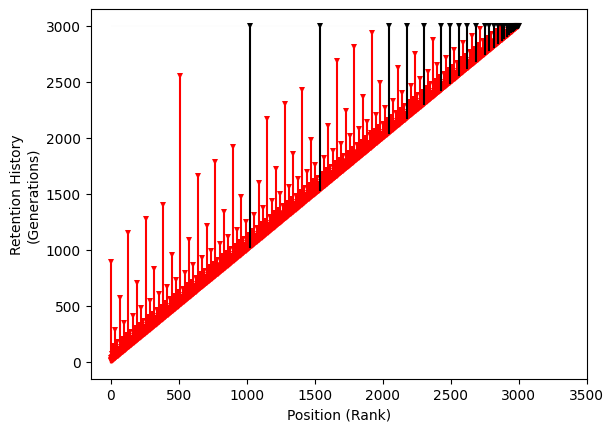

100%|██████████| 4096/4096 [00:00<00:00, 10382.93it/s]


teeplots/05/num-generations=4096+surface-size=128+viz=site-differentia-by-rank-heatmap+ynorm=log+ext=.pdf
teeplots/05/num-generations=4096+surface-size=128+viz=site-differentia-by-rank-heatmap+ynorm=log+ext=.png


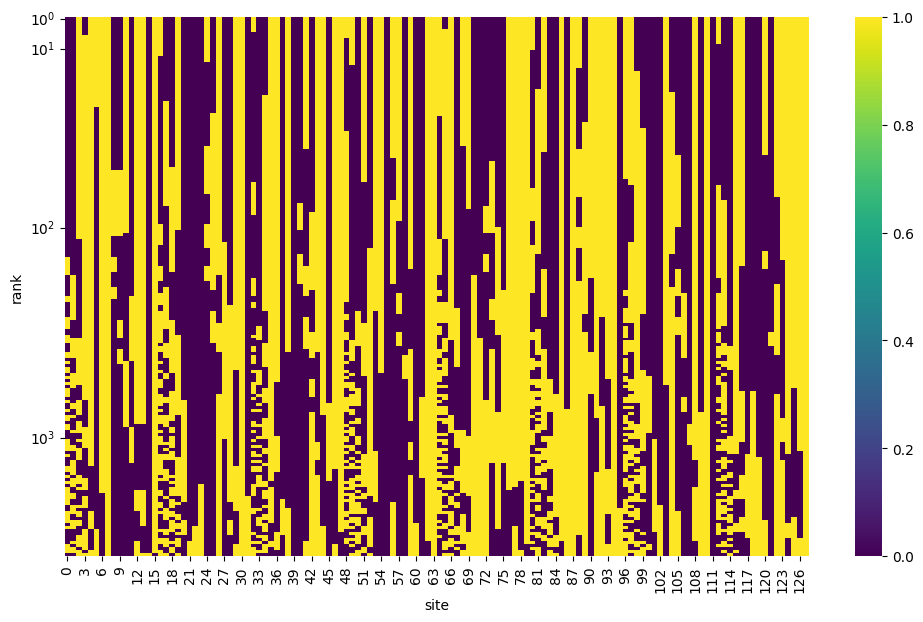

teeplots/05/num-generations=4096+surface-size=128+viz=site-differentia-by-rank-heatmap+ynorm=linear+ext=.pdf
teeplots/05/num-generations=4096+surface-size=128+viz=site-differentia-by-rank-heatmap+ynorm=linear+ext=.png


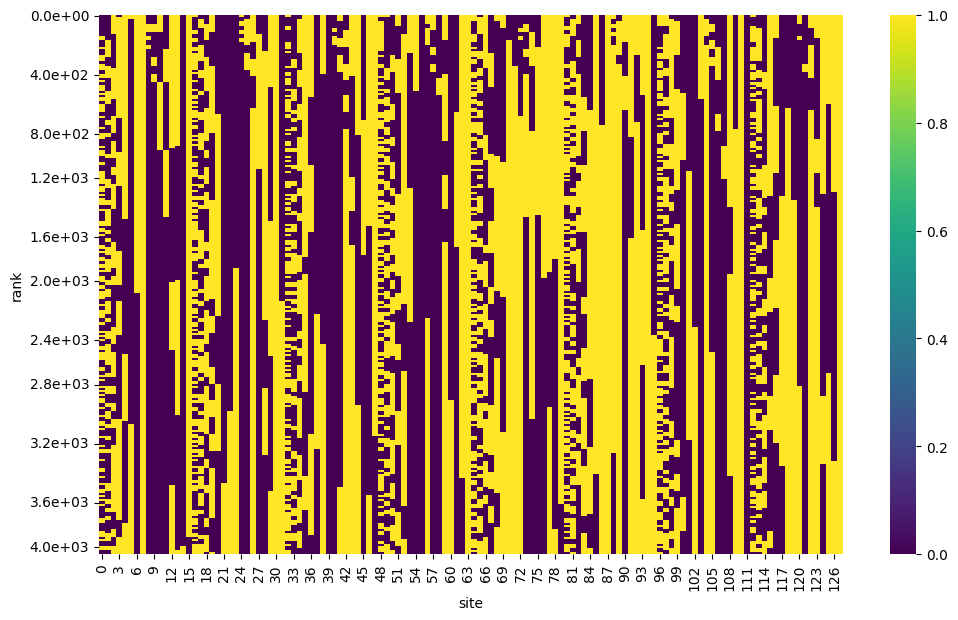

teeplots/05/cnorm=log+num-generations=4096+surface-size=128+viz=site-deposition-rank-by-rank-heatmap+ynorm=log+ext=.pdf
teeplots/05/cnorm=log+num-generations=4096+surface-size=128+viz=site-deposition-rank-by-rank-heatmap+ynorm=log+ext=.png


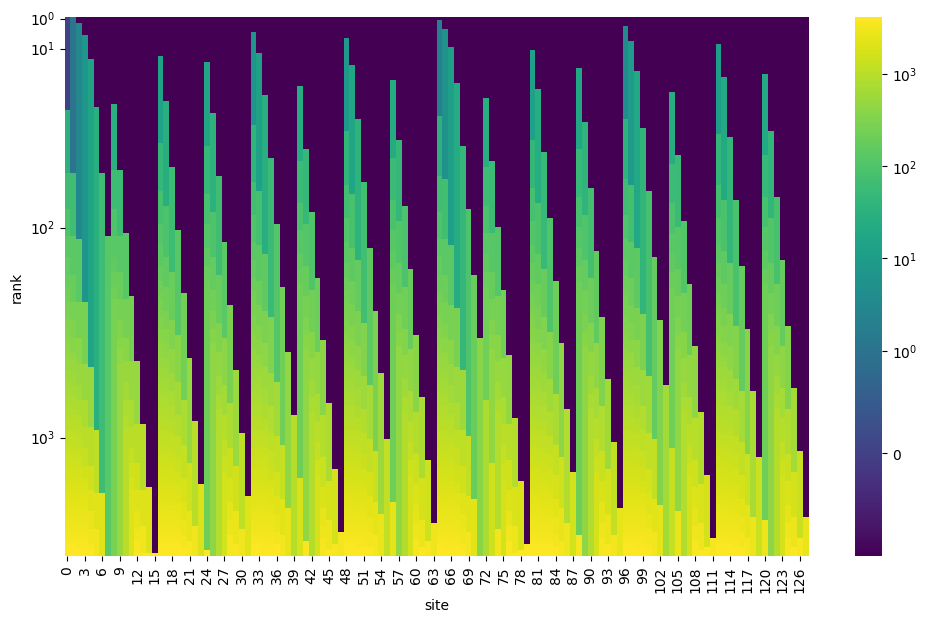

teeplots/05/cnorm=None+num-generations=4096+surface-size=128+viz=site-deposition-rank-by-rank-heatmap+ynorm=linear+ext=.pdf
teeplots/05/cnorm=None+num-generations=4096+surface-size=128+viz=site-deposition-rank-by-rank-heatmap+ynorm=linear+ext=.png


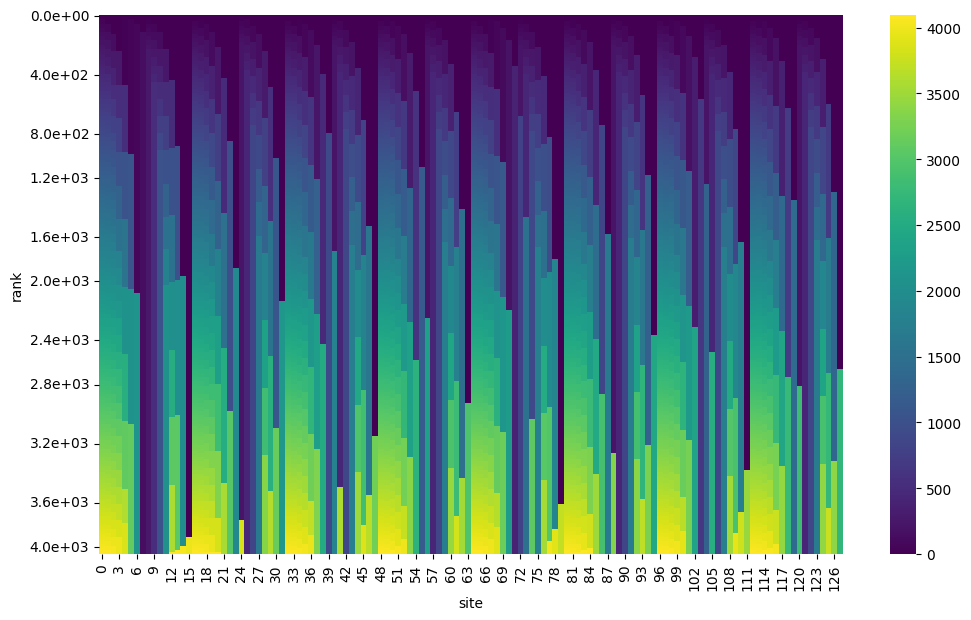

teeplots/05/num-generations=4096+surface-size=128+viz=site-hanoi-value-by-rank-heatmap+ext=.pdf
teeplots/05/num-generations=4096+surface-size=128+viz=site-hanoi-value-by-rank-heatmap+ext=.png


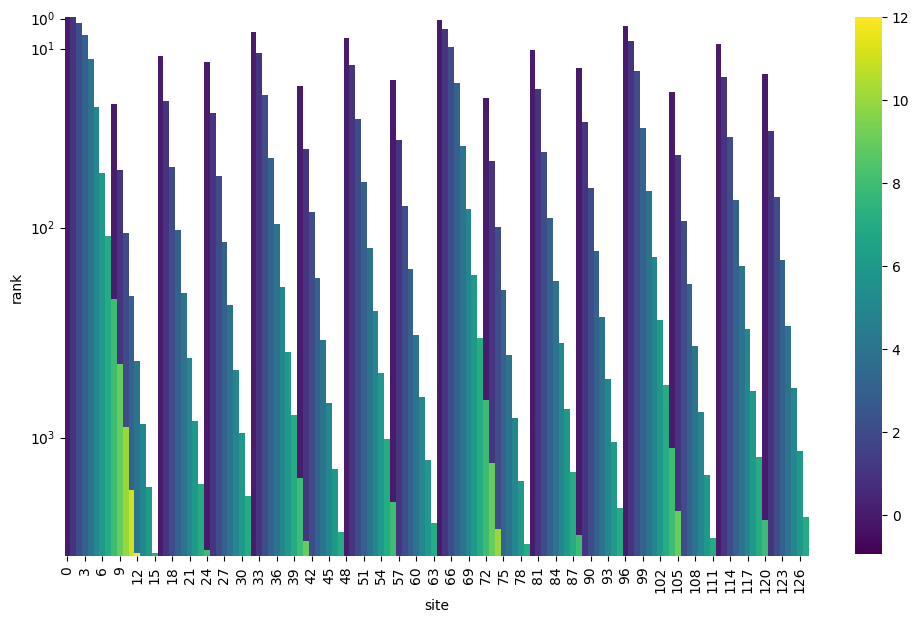

teeplots/05/num-generations=4096+surface-size=128+viz=site-hanoi-value-by-rank-heatmap+ynorm=linear+ext=.pdf
teeplots/05/num-generations=4096+surface-size=128+viz=site-hanoi-value-by-rank-heatmap+ynorm=linear+ext=.png


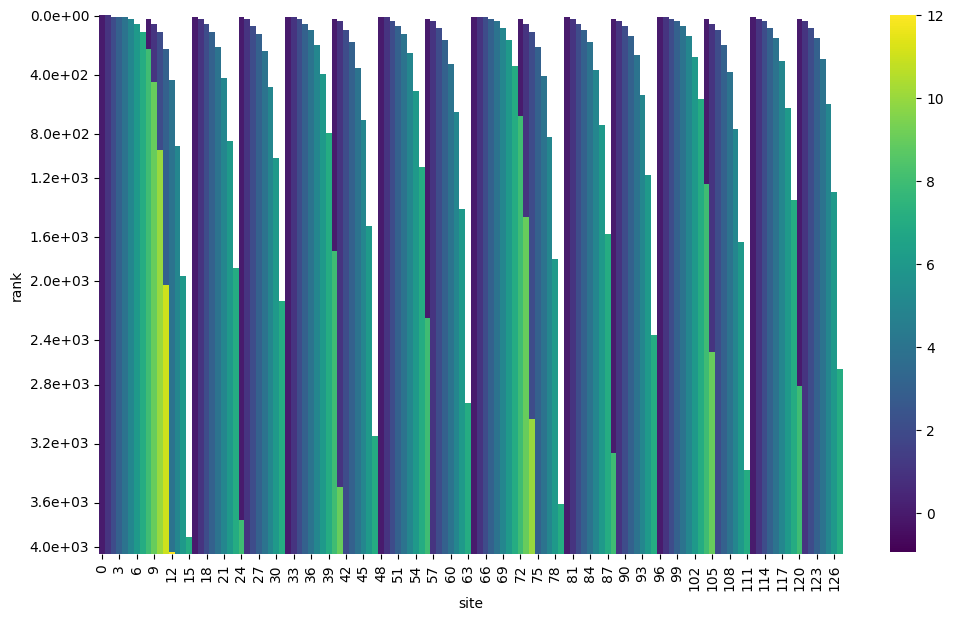

teeplots/05/cnorm=log+num-generations=4096+surface-size=128+viz=site-deposition-depth-by-rank-heatmap+ynorm=log+ext=.pdf
teeplots/05/cnorm=log+num-generations=4096+surface-size=128+viz=site-deposition-depth-by-rank-heatmap+ynorm=log+ext=.png


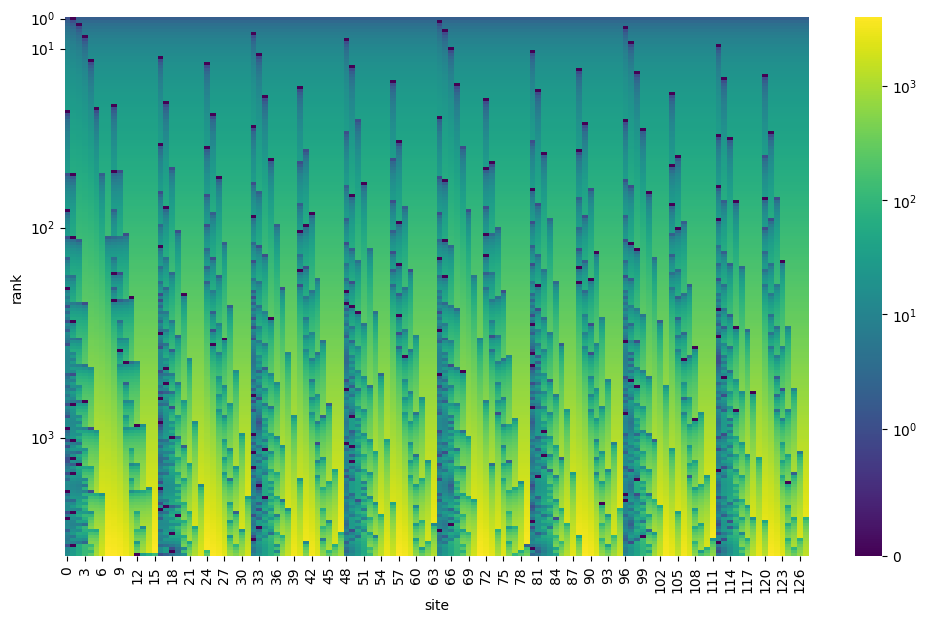

teeplots/05/cnorm=log+num-generations=4096+surface-size=128+viz=site-deposition-depth-by-rank-heatmap+ynorm=linear+ext=.pdf
teeplots/05/cnorm=log+num-generations=4096+surface-size=128+viz=site-deposition-depth-by-rank-heatmap+ynorm=linear+ext=.png


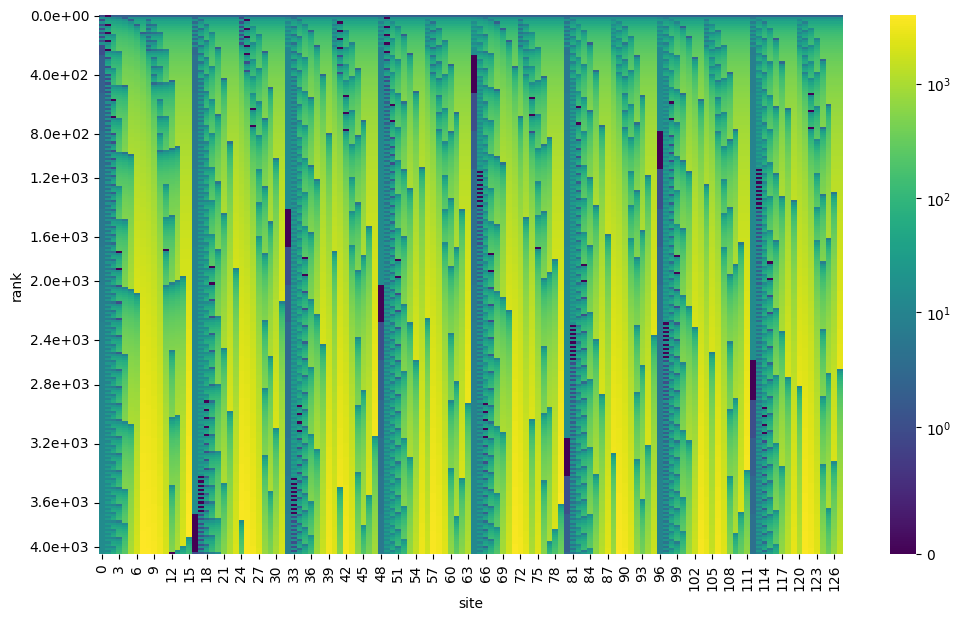

100%|██████████| 2998/2998 [00:09<00:00, 314.85it/s]


teeplots/05/num-generations=4096+surface-size=128+viz=stratum-persistence-dripplot+ext=.pdf
teeplots/05/num-generations=4096+surface-size=128+viz=stratum-persistence-dripplot+ext=.png


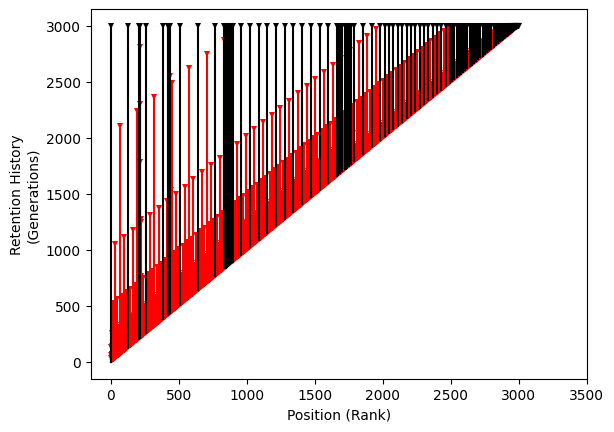

100%|██████████| 4096/4096 [00:00<00:00, 4341.94it/s]


teeplots/05/num-generations=4096+surface-size=512+viz=site-differentia-by-rank-heatmap+ynorm=log+ext=.pdf
teeplots/05/num-generations=4096+surface-size=512+viz=site-differentia-by-rank-heatmap+ynorm=log+ext=.png


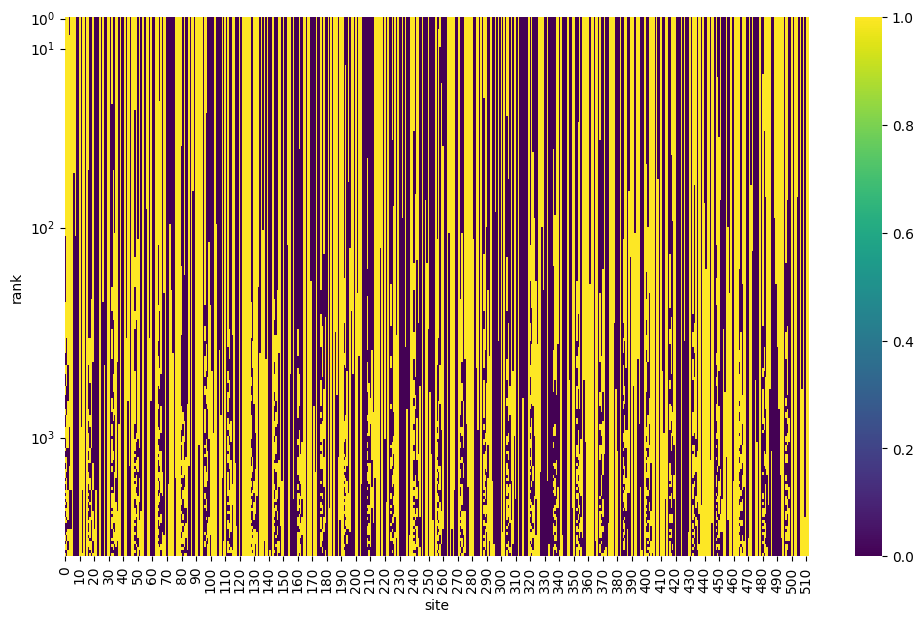

teeplots/05/num-generations=4096+surface-size=512+viz=site-differentia-by-rank-heatmap+ynorm=linear+ext=.pdf
teeplots/05/num-generations=4096+surface-size=512+viz=site-differentia-by-rank-heatmap+ynorm=linear+ext=.png


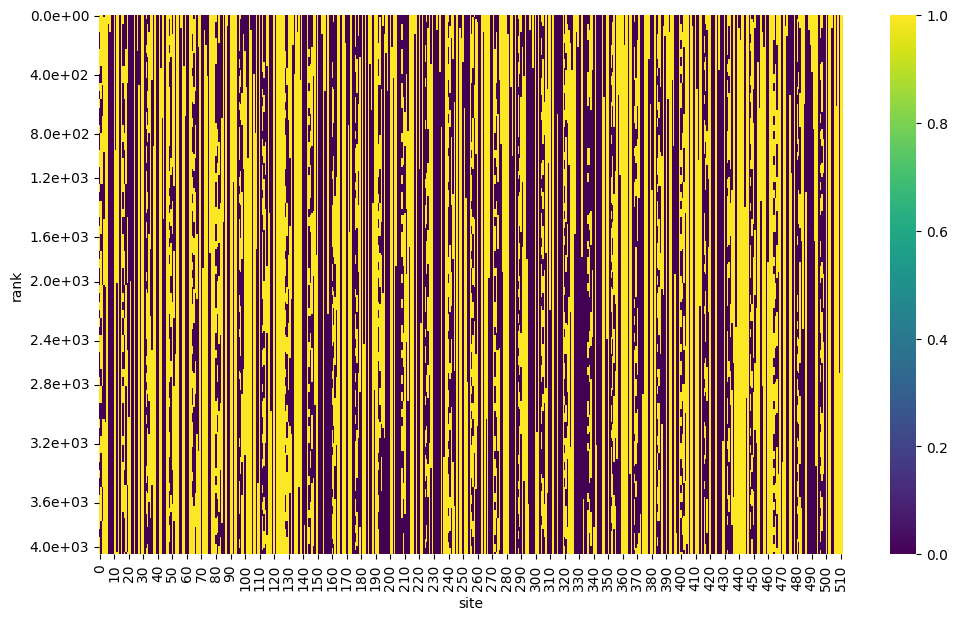

teeplots/05/cnorm=log+num-generations=4096+surface-size=512+viz=site-deposition-rank-by-rank-heatmap+ynorm=log+ext=.pdf
teeplots/05/cnorm=log+num-generations=4096+surface-size=512+viz=site-deposition-rank-by-rank-heatmap+ynorm=log+ext=.png


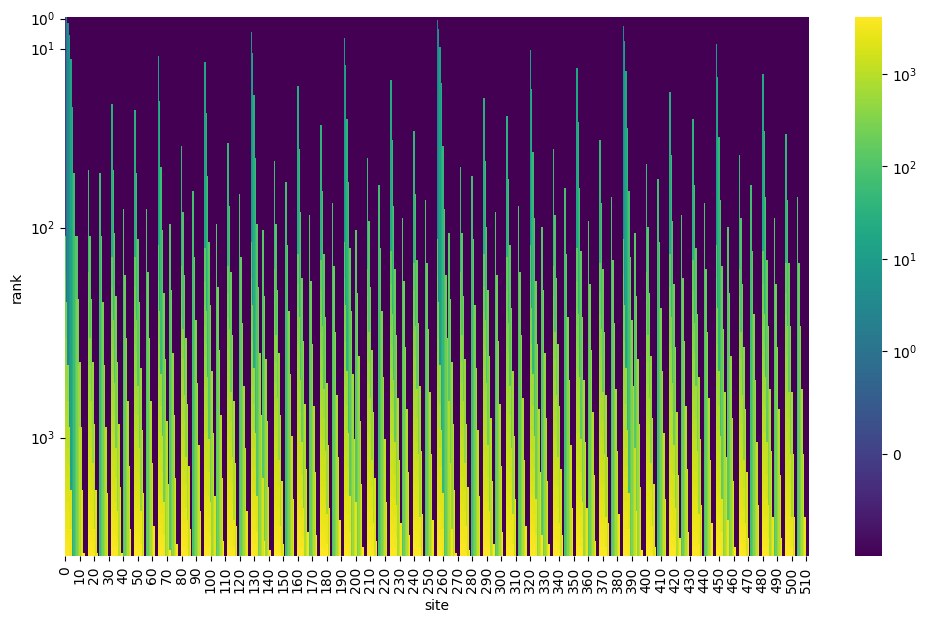

teeplots/05/cnorm=None+num-generations=4096+surface-size=512+viz=site-deposition-rank-by-rank-heatmap+ynorm=linear+ext=.pdf
teeplots/05/cnorm=None+num-generations=4096+surface-size=512+viz=site-deposition-rank-by-rank-heatmap+ynorm=linear+ext=.png


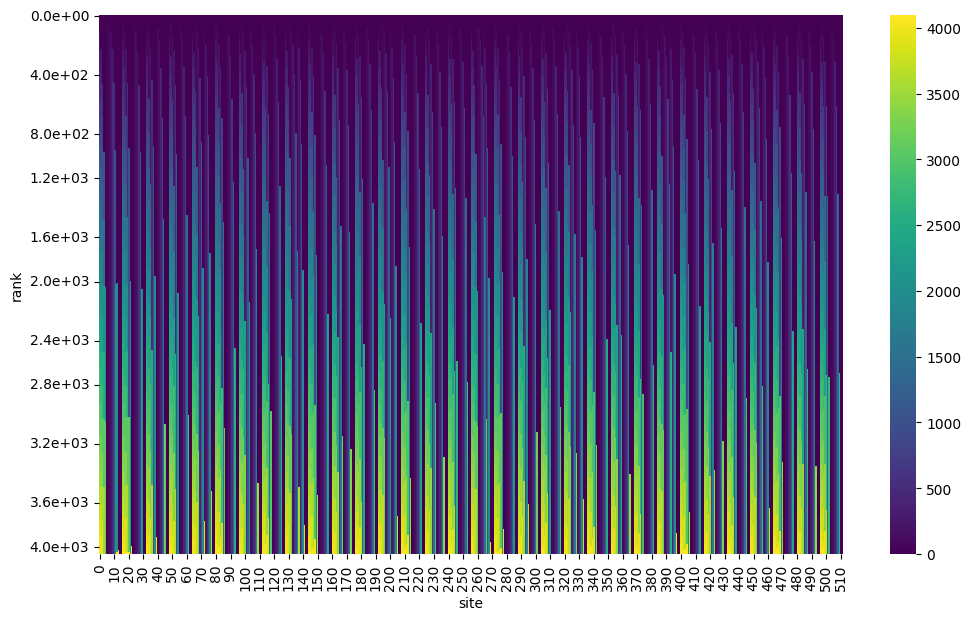

teeplots/05/num-generations=4096+surface-size=512+viz=site-hanoi-value-by-rank-heatmap+ext=.pdf
teeplots/05/num-generations=4096+surface-size=512+viz=site-hanoi-value-by-rank-heatmap+ext=.png


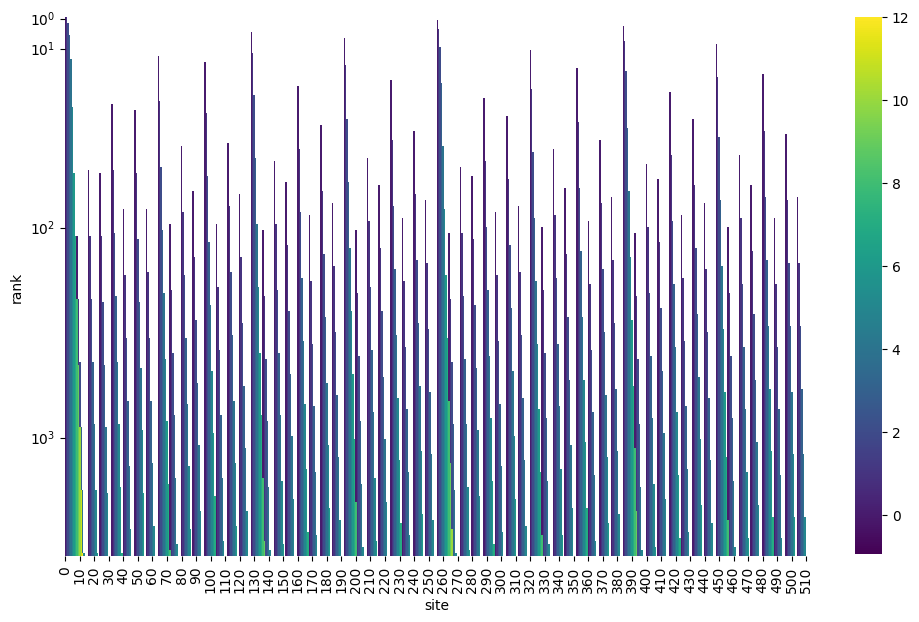

teeplots/05/num-generations=4096+surface-size=512+viz=site-hanoi-value-by-rank-heatmap+ynorm=linear+ext=.pdf
teeplots/05/num-generations=4096+surface-size=512+viz=site-hanoi-value-by-rank-heatmap+ynorm=linear+ext=.png


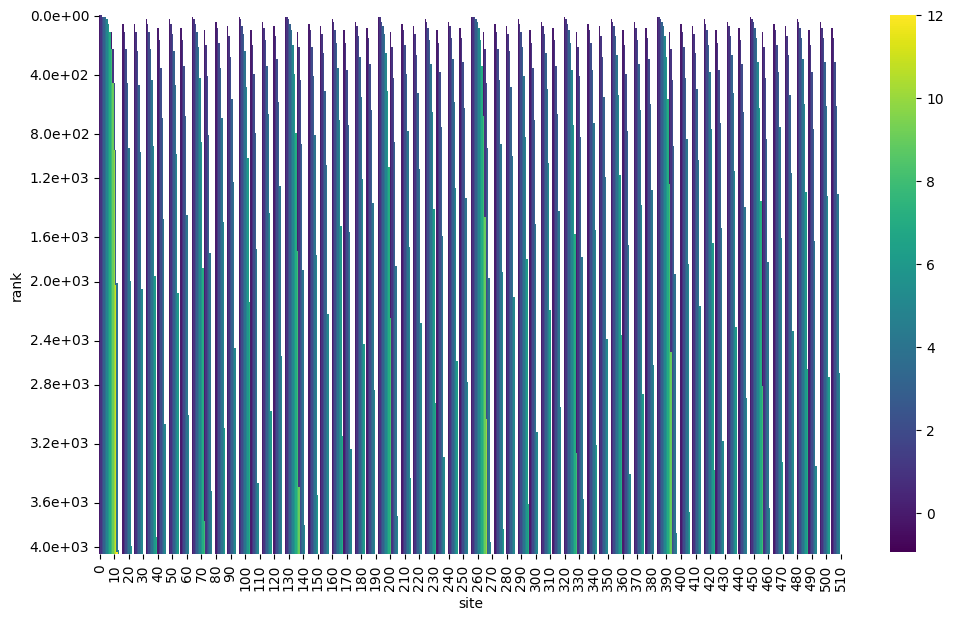

teeplots/05/cnorm=log+num-generations=4096+surface-size=512+viz=site-deposition-depth-by-rank-heatmap+ynorm=log+ext=.pdf
teeplots/05/cnorm=log+num-generations=4096+surface-size=512+viz=site-deposition-depth-by-rank-heatmap+ynorm=log+ext=.png


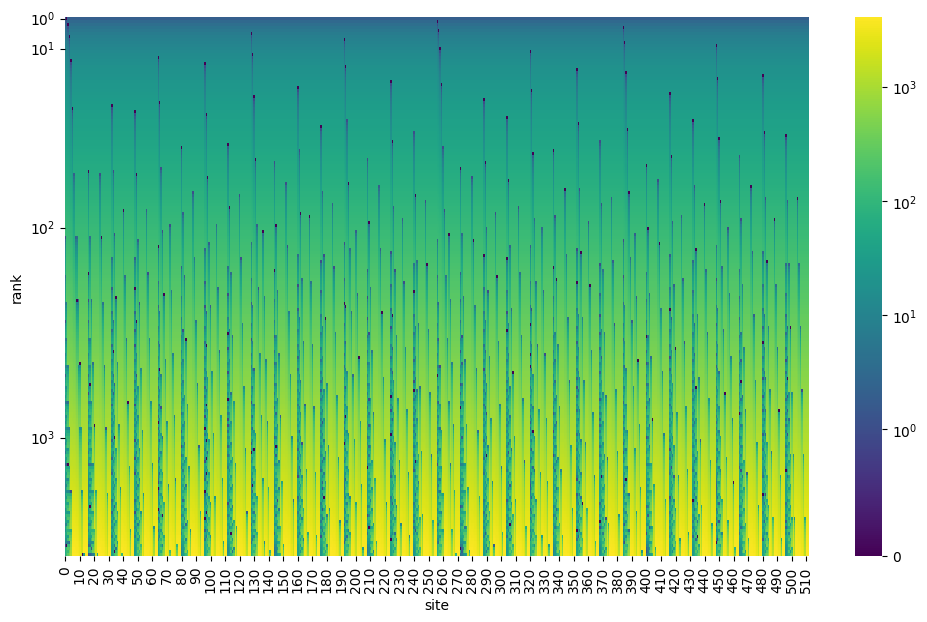

teeplots/05/cnorm=log+num-generations=4096+surface-size=512+viz=site-deposition-depth-by-rank-heatmap+ynorm=linear+ext=.pdf
teeplots/05/cnorm=log+num-generations=4096+surface-size=512+viz=site-deposition-depth-by-rank-heatmap+ynorm=linear+ext=.png


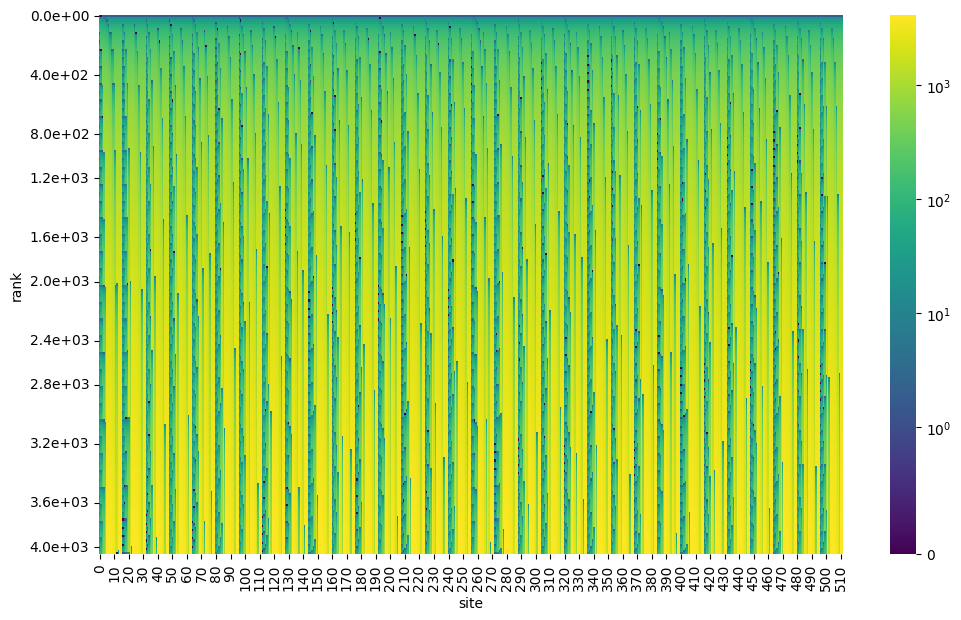

100%|██████████| 2998/2998 [00:13<00:00, 214.62it/s]


teeplots/05/num-generations=4096+surface-size=512+viz=stratum-persistence-dripplot+ext=.pdf
teeplots/05/num-generations=4096+surface-size=512+viz=stratum-persistence-dripplot+ext=.png


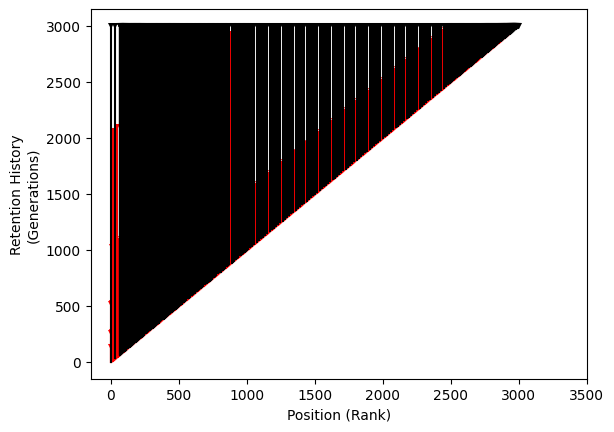

In [33]:
for surface_size_exp in range(3, 10, 2):
    surface_size = 2**surface_size_exp
    display(HTML(f"<h3>surface size {surface_size}</h3>"))

    num_generations = min(
        # don't run out of memory
        2**18 if surface_size_exp < 7 else 2**12,
        get_surface_rank_capacity(surface_size - 1),
    )

    surface_history_df = pylib.site_selection_eval.make_surface_history_df(
        get_deposition_site_at_rank,
        surface_size=surface_size,
        num_generations=num_generations,
        progress_wrap=tqdm,
    )

    # ========================
    kwargs = dict(
        ynorm="log",
    )
    pylib.tee_release(
        pylib.site_selection_viz.site_differentia_by_rank_heatmap,
        surface_history_df,
        **kwargs,
        teeplot_outattrs={
            **{
                "num-generations": num_generations,
                "surface-size": surface_size,
            },
            **kwargs,
        },
        teeplot_subdir="05",
    )

    # ========================
    kwargs = dict(
        ynorm="linear",
    )
    pylib.tee_release(
        pylib.site_selection_viz.site_differentia_by_rank_heatmap,
        surface_history_df,
        **kwargs,
        teeplot_outattrs={
            **{
                "num-generations": num_generations,
                "surface-size": surface_size,
            },
            **kwargs,
        },
        teeplot_subdir="05",
    )

    # ========================
    kwargs = dict(
        cnorm="log",
        ynorm="log",
    )
    pylib.tee_release(
        pylib.site_selection_viz.site_deposition_rank_by_rank_heatmap,
        surface_history_df,
        **kwargs,
        teeplot_outattrs={
            **{
                "num-generations": num_generations,
                "surface-size": surface_size,
            },
            **kwargs,
        },
        teeplot_subdir="05",
    )

    # ========================
    kwargs = dict(
        cnorm=None,
        ynorm="linear",
    )
    pylib.tee_release(
        pylib.site_selection_viz.site_deposition_rank_by_rank_heatmap,
        surface_history_df,
        **kwargs,
        teeplot_outattrs={
            **{
                "num-generations": num_generations,
                "surface-size": surface_size,
            },
            **kwargs,
        },
        teeplot_subdir="05",
    )

    # ========================
    pylib.tee_release(
        pylib.site_selection_viz.site_hanoi_value_by_rank_heatmap,
        surface_history_df,
        teeplot_outattrs={
            "num-generations": num_generations,
            "surface-size": surface_size,
        },
        teeplot_subdir="05",
    )

    # ========================
    kwargs = dict(
        ynorm="linear",
    )
    pylib.tee_release(
        pylib.site_selection_viz.site_hanoi_value_by_rank_heatmap,
        surface_history_df,
        **kwargs,
        teeplot_outattrs={
            **{
                "num-generations": num_generations,
                "surface-size": surface_size,
            },
            **kwargs,
        },
        teeplot_subdir="05",
    )

    # ========================
    kwargs = dict(
        cnorm="log",
        ynorm="log",
    )
    pylib.tee_release(
        pylib.site_selection_viz.site_deposition_depth_by_rank_heatmap,
        surface_history_df,
        **kwargs,
        teeplot_outattrs={
            **{
                "num-generations": num_generations,
                "surface-size": surface_size,
            },
            **kwargs,
        },
        teeplot_subdir="05",
    )

    # ========================
    kwargs = dict(
        cnorm="log",
        ynorm="linear",
    )
    pylib.tee_release(
        pylib.site_selection_viz.site_deposition_depth_by_rank_heatmap,
        surface_history_df,
        **kwargs,
        teeplot_outattrs={
            **{
                "num-generations": num_generations,
                "surface-size": surface_size,
            },
            **kwargs,
        },
        teeplot_subdir="05",
    )

    # ========================
    pylib.tee_release(
        pylib.site_selection_viz.stratum_persistence_dripplot,
        surface_history_df[surface_history_df["rank"] < 3000],
        teeplot_outattrs={
            "num-generations": num_generations,
            "surface-size": surface_size,
        },
        progress_wrap=tqdm,
        teeplot_subdir="05",
    )


100%|██████████| 300/300 [00:00<00:00, 17733.15it/s]


teeplots/./hue=deposition-rank+num-generations=300+surface-size=32+viz=scatter-move-legend+x=rank+y=site+ext=.pdf
teeplots/./hue=deposition-rank+num-generations=300+surface-size=32+viz=scatter-move-legend+x=rank+y=site+ext=.png


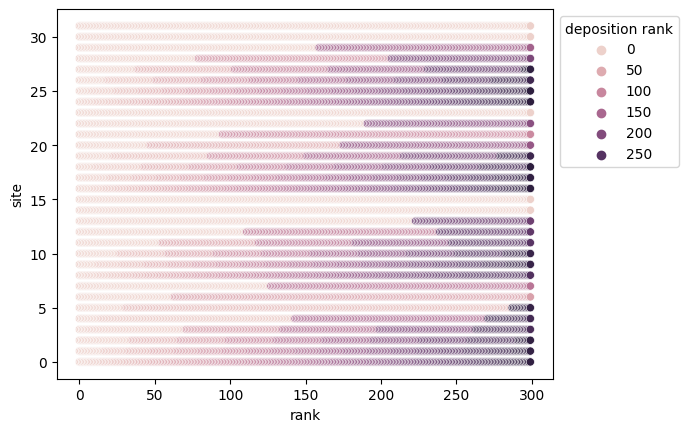

teeplots/./hue=site+num-generations=300+surface-size=32+viz=scatter-invert+x=deposition-rank+y=rank+ext=.pdf
teeplots/./hue=site+num-generations=300+surface-size=32+viz=scatter-invert+x=deposition-rank+y=rank+ext=.png


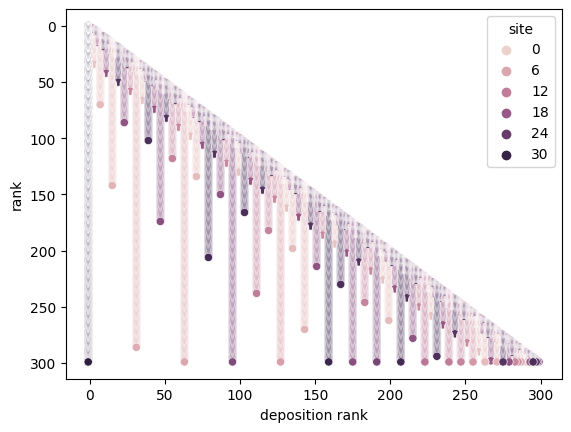

teeplots/./hue=site+num-generations=300+surface-size=32+viz=scatter-invert-zoom+x=deposition-rank+y=rank+ext=.pdf
teeplots/./hue=site+num-generations=300+surface-size=32+viz=scatter-invert-zoom+x=deposition-rank+y=rank+ext=.png


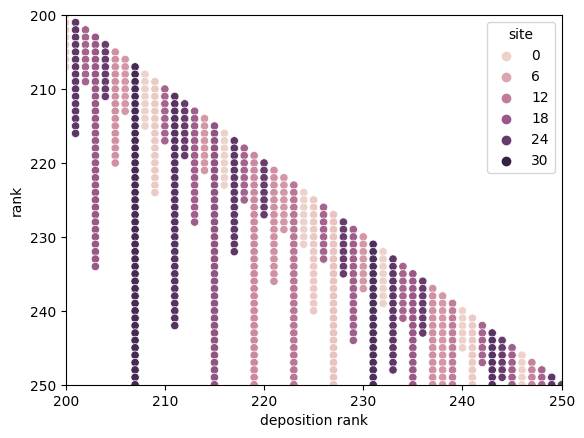

In [34]:
surface_size = 32
num_generations = 300

surface_history_df = pylib.site_selection_eval.make_surface_history_df(
    get_deposition_site_at_rank,
    surface_size,
    num_generations,
    tqdm,
)


# ========================
def scatter_move_legend(*args, **kwargs) -> None:
    ax = sns.scatterplot(
        *args,
        **kwargs,
    )
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))


pylib.tee_release(
    scatter_move_legend,
    data=surface_history_df,
    x="rank",
    y="site",
    hue="deposition rank",
    teeplot_outattrs={
        "num-generations": num_generations,
        "surface-size": surface_size,
    },
)


# ========================
def scatter_invert(*args, **kwargs) -> None:
    sns.scatterplot(
        *args,
        **kwargs,
    ).invert_yaxis()


pylib.tee_release(
    scatter_invert,
    data=surface_history_df,
    x="deposition rank",
    y="rank",
    hue="site",
    teeplot_outattrs={
        "num-generations": num_generations,
        "surface-size": surface_size,
    },
)


# ========================
def scatter_invert_zoom(*args, **kwargs) -> None:
    ax = sns.scatterplot(
        *args,
        **kwargs,
    )
    ax.set_xlim([200, 250])
    ax.set_ylim([200, 250])
    ax.invert_yaxis()


pylib.tee_release(
    scatter_invert_zoom,
    data=surface_history_df,
    x="deposition rank",
    y="rank",
    hue="site",
    teeplot_outattrs={
        "num-generations": num_generations,
        "surface-size": surface_size,
    },
)


# Section 3: Implement `get_deposition_site_at_rank`


## Section 3a: Prepare Support


In [35]:
def get_reservation_index_elimination_rank(
    hanoi_value: int,
    reservation_index: int,
    surface_size: int,
) -> typing.Optional[int]:

    first_incidence_rank = pylib.hanoi.get_index_of_hanoi_value_nth_incidence(
        hanoi_value, 0
    )
    max_reservations_provided = get_num_reservations_provided(
        hanoi_value=hanoi_value,
        surface_size=surface_size,
        rank=first_incidence_rank,
    )
    if reservation_index == 0:
        # special case because we implicitly assume
        # always at least one reservation index
        res = get_surface_rank_capacity(surface_size) - 1
        assert res
        return res
    elif reservation_index >= max_reservations_provided:
        return None
    else:

        def predicate(rank: int) -> bool:
            return (
                get_num_reservations_provided(
                    hanoi_value=hanoi_value,
                    surface_size=surface_size,
                    rank=rank,
                )
                <= reservation_index
            )

        assert not predicate(0)
        upper_bound = get_surface_rank_capacity(surface_size) - 1
        assert predicate(upper_bound)
        res = (
            inch.binary_search(
                predicate,
                first_incidence_rank,
                # upper bound prevents assertion errors from out of bounds queries
                upper_bound,
            )
        )
        assert res, {
            "first_incidence_rank": first_incidence_rank,
            "max_reservations_provided": max_reservations_provided,
            "res": res,
            "reservation_index": reservation_index,
            "surface_size": surface_size,
            "upper_bound": upper_bound,
        }
        return res


pylib.jupyter_hide_toggle()


In [36]:
# test get_reservation_index_elimination_rank
# helper function for test
def make_num_reservations_provided_df(surface_size: int) -> pd.DataFrame:
    num_generations = min(
        2**12,
        get_surface_rank_capacity(surface_size) - 1,
    )
    records = []
    max_hanoi_value = pylib.hanoi.get_max_hanoi_value_through_index(
        num_generations - 1
    )
    for hanoi_value in range(max_hanoi_value):
        first_incidence_rank = (
            pylib.hanoi.get_index_of_hanoi_value_nth_incidence(hanoi_value, 0)
        )
        for rank in tqdm(range(first_incidence_rank, num_generations)):
            num_reservations_provided = get_num_reservations_provided(
                hanoi_value=hanoi_value,
                surface_size=surface_size,
                rank=rank,
            )
            incidence_count = pylib.hanoi.get_incidence_count_of_hanoi_value_through_index(
                hanoi_value,
                rank,
            )
            assert incidence_count
            records.append(
                {
                    "rank": rank,
                    "hanoi value": hanoi_value,
                    "hanoi incidence": incidence_count - 1,
                    "num reservations provided": num_reservations_provided,
                }
            )

    return pd.DataFrame.from_records(records)


pylib.jupyter_hide_toggle(hide=True)


<IPython.core.display.Javascript object>

100%|██████████| 2049/2049 [00:00<00:00, 45738.75it/s]


,rank,hanoi value,hanoi incidence,num reservations provided
0,0,0,0,16
1,1,0,0,8
2,2,0,1,8
3,3,0,1,8
4,4,0,2,8
...,...,...,...,...
45064,4091,11,0,2
45065,4092,11,0,2
45066,4093,11,0,2
45067,4094,11,0,2


<IPython.core.display.Javascript object>

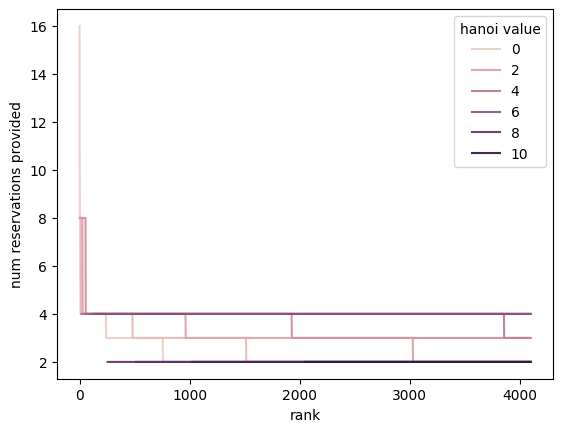

In [37]:
# test get_reservation_index_elimination_rank
# demo helper function for test
nrp_df = make_num_reservations_provided_df(32)

display(nrp_df)

sns.lineplot(
    data=nrp_df,
    x="rank",
    y="num reservations provided",
    hue="hanoi value",
)

pylib.jupyter_hide_toggle(hide=True)


In [38]:
# test get_reservation_index_elimination_rank
# actual test

for surface_size in 16, 32, 64:
    nrp_df = make_num_reservations_provided_df(surface_size)

    for hanoi_value, hv_df in nrp_df.groupby("hanoi value"):
        assert hv_df["num reservations provided"].is_monotonic_decreasing
        max_reservations_provided = hv_df["num reservations provided"].max()
        expected = None
        actual = get_reservation_index_elimination_rank(
            hanoi_value=hanoi_value,
            reservation_index=max_reservations_provided,
            surface_size=surface_size,
        )
        assert expected == actual, {
            "expected": expected,
            "actual": actual,
            "hanoi value": hanoi_value,
            "reservation index": max_reservations_provided,
            "surface size": surface_size,
        }
        max_covered_rank = hv_df["rank"].max()

        for nrp, nrp_df_ in hv_df.groupby("num reservations provided"):
            assert nrp
            reservation_index = nrp - 1
            expected_last = nrp_df_["rank"].max()
            actual_last = (
                get_reservation_index_elimination_rank(
                    hanoi_value=hanoi_value,
                    reservation_index=reservation_index,
                    surface_size=surface_size,
                )
                - 1
            )
            assert actual_last >= 0
            if (
                expected_last < max_covered_rank
            ):  # skip where coverage goes off end of sampled ranks
                assert expected_last == actual_last, {
                    "expected last": expected_last,
                    "actual last": actual_last,
                    "hanoi value": hanoi_value,
                    "reservation index": reservation_index,
                    "surface size": surface_size,
                }


pylib.jupyter_hide_toggle(hide=True)


100%|██████████| 2049/2049 [00:00<00:00, 43362.64it/s]


<IPython.core.display.Javascript object>

In [39]:
def iter_candidate_reservation_sizes(
    site: int,
    rank: int,
) -> typing.Iterator[int]:
    # this is going BACK in time
    naive_reservation_size = get_num_sites_reserved_per_incidence_at_rank(rank)

    reservation_size = naive_reservation_size
    while reservation_size:
        candidate_hanoi_value = site % reservation_size
        yield reservation_size
        reservation_size //= 2


In [40]:
def iter_candidate_hanoi_occupants(
    site: int,
    rank: int,
) -> typing.Iterator[int]:
    # this is going BACK in time
    for candidate_reservation_size in iter_candidate_reservation_sizes(site, rank):
        candidate_hanoi_value = site % candidate_reservation_size
        yield candidate_hanoi_value


pylib.jupyter_hide_toggle()


In [41]:
# test iter_candidate_hanoi_occupants
for surface_size in 16, 32, 64:
    capacity = get_surface_rank_capacity(surface_size)
    for rank in it.chain(
        range(300),
        map(int, np.linspace(0, capacity, num=100, dtype=int)),
    ):
        {*iter_candidate_hanoi_occupants(0, rank)} == {0}

        for site in range(surface_size):
            assert hstrat_aux.is_nonincreasing(
                iter_candidate_hanoi_occupants(site, rank)
            )

assert {*iter_candidate_hanoi_occupants(1, 2)} == {0, 1}

assert {*iter_candidate_hanoi_occupants(1, 5559)} == {0, 1}

assert {*iter_candidate_hanoi_occupants(6, 5)} == {0, 2}

assert {*iter_candidate_hanoi_occupants(5, 5)} == {0, 1}

assert {*iter_candidate_hanoi_occupants(7, 5)} == {0, 1, 3}


assert {*iter_candidate_hanoi_occupants(6, 16)} == {0, 2, 6}

assert {*iter_candidate_hanoi_occupants(5, 16)} == {0, 1, 5}

assert {*iter_candidate_hanoi_occupants(7, 16)} == {0, 1, 3, 7}

assert {*iter_candidate_hanoi_occupants(8, 16)} == {0}

assert {*iter_candidate_hanoi_occupants(9, 16)} == {0, 1}

pylib.jupyter_hide_toggle(hide=True)


<IPython.core.display.Javascript object>

In [42]:
def iter_candidate_reservation_indices(
    site: int,
    surface_size: int,
    rank: int,
) -> typing.Iterator[int]:
    # this is going BACK in time

    for candidate_reservation_size in iter_candidate_reservation_sizes(site, rank):
        candidate_reservation_position = site // candidate_reservation_size
        candidate_reservation_index = (
            pylib.longevity_ordering_descending.get_longevity_index_of_mapped_position(
                candidate_reservation_position,
                surface_size // candidate_reservation_size,
            )
        )
        yield candidate_reservation_index


In [43]:
@pylib.log_args_and_result(logger, logging.DEBUG)
def calc_reservation_reference_incidence(
    hanoi_value: int,
    reservation_index: int,
    surface_size: int,
    focal_rank: int,
) -> int:
    num_reservations_provided = get_num_reservations_provided(
        hanoi_value=hanoi_value,
        surface_size=surface_size,
        rank=focal_rank,
    )
    assert num_reservations_provided
    assert reservation_index < num_reservations_provided, {
        "hanoi_value": hanoi_value,
        "reservation_index": reservation_index,
        "surface_size": surface_size,
        "focal_rank": focal_rank,
        "num_reservations_provided": num_reservations_provided,
    }

    num_incidences = pylib.hanoi.get_incidence_count_of_hanoi_value_through_index(
        hanoi_value,
        focal_rank,
    )
    assert num_incidences
    hanoi_incidence = num_incidences - 1

    incidence_position = hanoi_incidence % num_reservations_provided
    candidate_incidence = hanoi_incidence - incidence_position

    if reservation_index > incidence_position:
        # should only recurse once?
        cadence = pylib.hanoi.get_hanoi_value_index_cadence(hanoi_value)
        candidate_rank = pylib.hanoi.get_index_of_hanoi_value_nth_incidence(
            hanoi_value,
            candidate_incidence,
        )
        assert candidate_rank
        return calc_reservation_reference_incidence(
            hanoi_value,
            reservation_index,
            surface_size,
            candidate_rank - 1,
        )
    else:
        assert candidate_incidence % num_reservations_provided == 0, {
            "candidate_incidence": candidate_incidence,
            "num_reservations_provided": num_reservations_provided,
        }
        return candidate_incidence


In [44]:
# test calc_reservation_reference_rank test
# helper function for test
def make_reference_incidence_df(surface_size: int, max_generations: int = 2**12) -> pd.DataFrame:
    num_generations = min(
        max_generations,
        get_surface_rank_capacity(surface_size) - 1,
    )
    records = []
    surface_deposition_ranks = [-1] * surface_size
    surface_deposition_incidences = [-1] * surface_size
    for rank in tqdm(range(num_generations)):
        target_rank = get_deposition_site_at_rank(rank, surface_size)
        surface_deposition_ranks[target_rank] = rank
        surface_deposition_incidences[target_rank] = pylib.hanoi.get_hanoi_value_incidence_at_index(rank)

        max_hanoi_value = pylib.hanoi.get_max_hanoi_value_through_index(rank)
        for hanoi_value in range(max_hanoi_value):
            assert surface_deposition_ranks[hanoi_value] != -1
            assert surface_deposition_incidences[hanoi_value] != -1

            records.append(
                {
                    "rank": rank,
                    "hanoi value": hanoi_value,
                    "num reservations provided": get_num_reservations_provided(
                        hanoi_value=hanoi_value,
                        surface_size=surface_size,
                        rank=rank,
                    ),
                    "reference rank": surface_deposition_ranks[hanoi_value],
                    "reference incidence": surface_deposition_incidences[hanoi_value],
                }
            )


    return pd.DataFrame.from_records(records)


pylib.jupyter_hide_toggle(hide=True)


<IPython.core.display.Javascript object>

100%|██████████| 1000/1000 [00:00<00:00, 3716.15it/s]


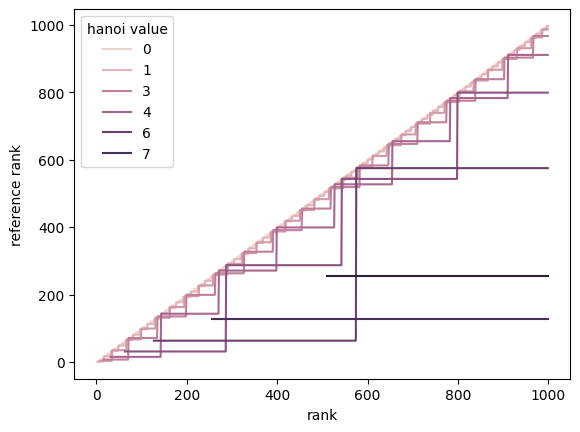

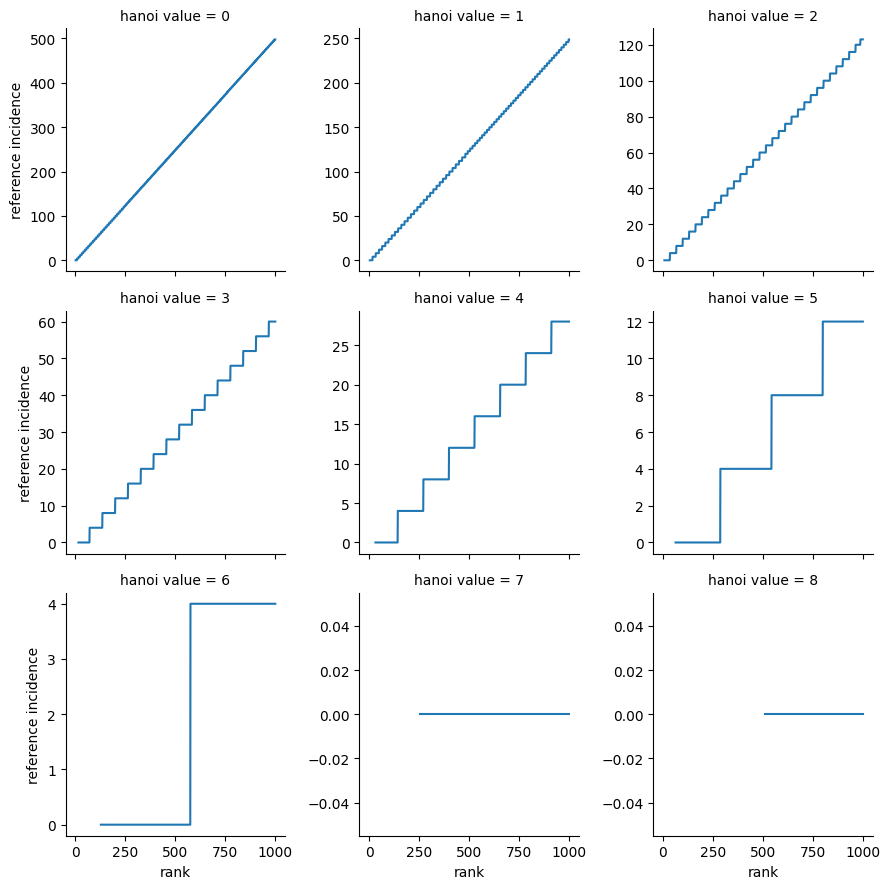

,rank,hanoi value,num reservations provided,reference rank,reference incidence
0,1,0,8,0,0
1,2,0,8,0,0
2,3,0,8,0,0
3,3,1,8,1,0
4,4,0,8,0,0
...,...,...,...,...,...
7982,999,4,4,911,28
7983,999,5,4,799,12
7984,999,6,4,575,4
7985,999,7,4,127,0


<IPython.core.display.Javascript object>

In [45]:
# test calc_reservation_reference_incidence test
# helper function for test

rr_df = make_reference_incidence_df(32, max_generations=1000)

sns.lineplot(
    data=rr_df,
    x="rank",
    y="reference rank",
    hue="hanoi value",
)
plt.show()

g = sns.FacetGrid(rr_df, col="hanoi value", col_wrap=3, sharey=False)
g.map_dataframe(sns.lineplot, x="rank", y="reference incidence")
plt.show()

display(rr_df)

pylib.jupyter_hide_toggle(hide=True)


In [46]:
# exploration for calc_reservation_reference_incidence
rr_df = make_reference_incidence_df(32, max_generations=100)

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    fil_df = rr_df[rr_df["hanoi value"] == 0]
    print(fil_df["reference rank"].unique())
    print(fil_df["reference incidence"].unique())
    display(fil_df)

pylib.jupyter_hide_toggle(hide=True)


100%|██████████| 100/100 [00:00<00:00, 5302.73it/s]

[ 0  8 16 24 32 40 48 56 64 72 80 88 96]
[ 0  4  8 12 16 20 24 28 32 36 40 44 48]


,rank,hanoi value,num reservations provided,reference rank,reference incidence
0,1,0,8,0,0
1,2,0,8,0,0
2,3,0,8,0,0
4,4,0,8,0,0
6,5,0,8,0,0
8,6,0,4,0,0
10,7,0,4,0,0
13,8,0,4,8,4
16,9,0,4,8,4
19,10,0,4,8,4


<IPython.core.display.Javascript object>

In [47]:
# exploration for calc_reservation_reference_incidence
rr_df = make_reference_incidence_df(32, max_generations=8000)

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    fil_df = rr_df[rr_df["hanoi value"] == 4]
    print(fil_df["reference rank"].unique())
    print(fil_df["reference incidence"].unique())
    display(fil_df[
        (fil_df["rank"] > 3850)
        & (fil_df["rank"] < 3860)
    ])

pylib.jupyter_hide_toggle(hide=True)


100%|██████████| 8000/8000 [00:02<00:00, 2671.96it/s]


[  15  143  271  399  527  655  783  911 1039 1167 1295 1423 1551 1679
 1807 1935 2063 2191 2319 2447 2575 2703 2831 2959 3087 3215 3343 3471
 3599 3727 3855 3951 4047 4143 4239 4335 4431 4527 4623 4719 4815 4911
 5007 5103 5199 5295 5391 5487 5583 5679 5775 5871 5967 6063 6159 6255
 6351 6447 6543 6639 6735 6831 6927 7023 7119 7215 7311 7407 7503 7599
 7695 7791 7887 7983]
[  0   4   8  12  16  20  24  28  32  36  40  44  48  52  56  60  64  68
  72  76  80  84  88  92  96 100 104 108 112 116 120 123 126 129 132 135
 138 141 144 147 150 153 156 159 162 165 168 171 174 177 180 183 186 189
 192 195 198 201 204 207 210 213 216 219 222 225 228 231 234 237 240 243
 246 249]


,rank,hanoi value,num reservations provided,reference rank,reference incidence
38282,3851,4,4,3727,116
38293,3852,4,4,3727,116
38304,3853,4,4,3727,116
38315,3854,4,4,3727,116
38326,3855,4,3,3855,120
38337,3856,4,3,3855,120
38348,3857,4,3,3855,120
38359,3858,4,3,3855,120
38370,3859,4,3,3855,120


<IPython.core.display.Javascript object>

In [48]:
# test calc_reservation_reference_rank test
# helper function for test
def make_dense_reference_incidence_df(surface_size: int, max_generations: int = 2**12) -> pd.DataFrame:
    num_generations = min(
        max_generations,
        get_surface_rank_capacity(surface_size) - 1,
    )
    surface_deposition_ranks = [-1] * surface_size
    surface_deposition_incidences = [-1] * surface_size
    surface_hanoi_values = [-1] * surface_size
    surface_deposition_reference_incidences = [-1] * surface_size
    surface_deposition_reference_ranks = [-1] * surface_size

    records = []
    for rank in tqdm(range(num_generations)):
        deposition_hanoi_value = pylib.hanoi.get_hanoi_value_at_index(rank)
        target_rank = get_deposition_site_at_rank(rank, surface_size)
        surface_hanoi_values[target_rank] = deposition_hanoi_value
        surface_deposition_ranks[target_rank] = rank
        surface_deposition_incidences[target_rank] = pylib.hanoi.get_hanoi_value_incidence_at_index(rank)
        surface_deposition_reference_ranks[target_rank] = surface_deposition_ranks[
            deposition_hanoi_value
        ]
        surface_deposition_reference_incidences[target_rank] = surface_deposition_incidences[
            deposition_hanoi_value
        ]

        for (
            site,
            site_hanoi_value,
            site_deposition_incidence,
            site_deposition_rank,
            site_deposition_reference_incidence,
            site_deposition_reference_rank,
        ) in zip(
            it.count(),
            surface_hanoi_values,
            surface_deposition_incidences,
            surface_deposition_ranks,
            surface_deposition_reference_incidences,
            surface_deposition_reference_ranks,
        ):
            if site_hanoi_value == -1:
                assert site_deposition_incidence == -1
                assert site_deposition_rank == -1
                assert site_deposition_reference_rank == -1
                continue

            num_reservations_provided = get_num_reservations_provided(
                hanoi_value=site_hanoi_value,
                surface_size=surface_size,
                rank=rank,
            )
            num_chunks = pylib.bit_ceil(num_reservations_provided)
            chunk_size = surface_size // num_chunks
            reservation_index = (
                pylib.longevity_ordering_descending.get_longevity_index_of_mapped_position(
                    site // chunk_size,
                    num_chunks,
                )
            )
            if site % chunk_size != site_hanoi_value or reservation_index >= num_reservations_provided:
                continue  # derelict sites, skip

            assert (site < chunk_size) == (reservation_index == 0), {
                "site": site,
                "reservation_index": reservation_index,
            }

            data = {
                "rank": rank,
                "site": site,
                "hanoi value": site_hanoi_value,
                "deposition incidence": site_deposition_incidence,
                "deposition rank": site_deposition_rank,
                "deposition reference incidence": site_deposition_reference_incidence,
                "deposition reference rank": site_deposition_reference_rank,
                "num reservations provided": num_reservations_provided,
                "reservation index": reservation_index,
                "chunk size": chunk_size,
                "num chunks": num_chunks,
            }
            records.append(data)

            assert reservation_index < num_reservations_provided, data

    return pd.DataFrame.from_records(records)


pylib.jupyter_hide_toggle(hide=True)


<IPython.core.display.Javascript object>

In [49]:
# test calc_reservation_reference_incidence
# actual test

for surface_size in 16, 32, 64:

    reference_incidence_df = make_dense_reference_incidence_df(surface_size)
    for index, row in reference_incidence_df.iterrows():
        actual = calc_reservation_reference_incidence(
            int(row["hanoi value"]),
            int(row["reservation index"]),
            surface_size,
            int(row["rank"]),
        )
        expected = row["deposition reference incidence"]
        if actual != expected:
            print(row)
        assert actual == expected, {
            "actual": actual,
            "expected": expected,
        }


100%|██████████| 4096/4096 [00:02<00:00, 2008.89it/s]


In [50]:
@pylib.log_args_and_result(logger, logging.DEBUG)
def calc_incidence_of_deposited_hanoi_value(
    hanoi_value: int,
    reservation_index: int,
    surface_size: int,
    focal_rank: int,
    _is_recurse = False,
) -> int:
    num_reservations_provided = get_num_reservations_provided(
        hanoi_value=hanoi_value,
        surface_size=surface_size,
        rank=focal_rank,
    )
    assert num_reservations_provided

    assert reservation_index <= num_reservations_provided

    focal_count = pylib.hanoi.get_incidence_count_of_hanoi_value_through_index(
        hanoi_value,
        focal_rank,
    )
    assert focal_count

    focal_incidence = focal_count - 1
    # this case (not enough deposits to reach reservation)
    # is handled elsewhere before this fn
    assert focal_incidence >= reservation_index

    # figure out where the modulus lines up at the zero position
    reference_incidence = calc_reservation_reference_incidence(
        hanoi_value = hanoi_value,
        reservation_index = reservation_index,
        surface_size = surface_size,
        focal_rank = focal_rank,
    )
    assert reference_incidence >= 0

    assert focal_incidence >= reference_incidence  # ? need to handle here?

    incidence_duration = focal_incidence - reference_incidence
    assert incidence_duration >= reservation_index

    logger.debug(
        {
            "focal_count": focal_count,
            "focal_incidence": focal_incidence,
            "incidence_duration": incidence_duration,
            "num_reservations_provided": num_reservations_provided,
            "reference_incidence": reference_incidence,
            "reservation_index": reservation_index,
            "surface_size": surface_size,
        },
    )

    res = reference_incidence + reservation_index
    assert res <= focal_incidence, {
        "res": res,
        "focal_incidence": focal_incidence,
        "reference incidence": reference_incidence,
        "reservation index": reservation_index,
    }  # make sure incidence has actually occured
    return res


In [51]:
@pylib.log_args_and_result(logger, logging.DEBUG)
def calc_rank_of_deposited_hanoi_value(
    hanoi_value: int,
    reservation_index: int,
    surface_size: int,
    focal_rank: int,
) -> int:
    incidence = calc_incidence_of_deposited_hanoi_value(
        hanoi_value,
        reservation_index,
        surface_size,
        focal_rank,
    )
    res = pylib.hanoi.get_index_of_hanoi_value_nth_incidence(
        hanoi_value,
        incidence,
    )
    assert res <= focal_rank, {
        "hanoi_value" : hanoi_value,
        "incidence" : incidence,
        "focal_rank" : focal_rank,
        "res": res,
        "reservation_index" : reservation_index,
        "surface_size" : surface_size,
    }
    return res


## Section 3b: Define `get_deposition_rank_at_site`


In [52]:
def get_deposition_rank_at_site(
    site: int, surface_size: int, num_depositions: int
) -> int:

    if num_depositions == 0:
        return 0

    rank = num_depositions - 1

    for candidate_hanoi_value, candidate_reservation_index in zip(
        iter_candidate_hanoi_occupants(site, rank),
        iter_candidate_reservation_indices(site, surface_size, rank),
    ):
        logger.debug(f"{candidate_hanoi_value=}")
        logger.debug(f"{candidate_reservation_index=}")
        deadline_rank = get_reservation_index_elimination_rank(
            candidate_hanoi_value,
            candidate_reservation_index,
            surface_size,
        )
        logger.debug(f"{deadline_rank=}")
        if deadline_rank is None:
            continue  # could this be a break?

        assert deadline_rank, {
            "candidate_hanoi_value": candidate_hanoi_value,
            "candidate_reservation_index": candidate_reservation_index,
            "rank": rank,
            "site": site,
            "surface_size": surface_size,
        }

        focal_rank = min(rank, deadline_rank - 1)
        assert focal_rank <= rank
        logger.debug(f"{focal_rank=}")

        hanoi_count = pylib.hanoi.get_incidence_count_of_hanoi_value_through_index(
            candidate_hanoi_value,
            focal_rank,
        )
        if hanoi_count > candidate_reservation_index:
            res = calc_rank_of_deposited_hanoi_value(
                candidate_hanoi_value,
                candidate_reservation_index,
                surface_size,
                focal_rank,
            )
            assert res <= rank, {
                "candidate_hanoi_value": candidate_hanoi_value,
                "candidate_reservation_index": candidate_reservation_index,
                "deadline_rank": deadline_rank,
                "focal_rank": focal_rank,
                "hanoi_count": hanoi_count,
                "rank": rank,
                "res": res,
                "site": site,
                "surface_size": surface_size,
            }
            return res

    return 0


## Section 4: Evaluate `get_deposition_rank_at_site`


## Section 4a: Unit Test


In [53]:
# test get_deposition_rank_at_site
# assert [
#     get_deposition_rank_at_site(0, 16, num_depositions) for num_depositions in range(22)
# ] == [
#         # deposition site
#         #     # num_reservations
#         #     #     # hanoi sequence (0-based):
#     0,  # ~~~~ n/a ~~~~
#     0,  # 0,  # 16, # 0,
#     0,  # 1,  # 8,  # 1,
#     0,  # 8,  # 8,  # 0,
#     0,  # 2,  # 4,  # 2,
#     0,  # 4,  # 4,  # 0,
#     0,  # 9,  # 4,  # 1,
#     0,  # 12, # 4,  # 0,
#     0,  # 3,  # 4,  # 3,
#     8,  # 0,  # 4,  # 0,
#     8,  # 5,  # 4,  # 1,
#     8,  # 8,  # 4,  # 0,
#     8,  # 10, # 4,  # 2,
#     8,  # 4,  # 4,  # 0,
#     8,  # 13, # 4,  # 1,
#     8,  # 12, # 4,  # 0,
#     8,  # 4,  # 2,  # 4,
#     16, # 0,  # 2,  # 0,
#     16, # 1,  # 2,  # 1,
#     16, # 8,  # 2,  # 0,
#     16, # 6,  # 2,  # 2,
#     20, # 0,  # 2,  # 0,
# ]
# assert [
#     get_deposition_rank_at_site(1, 16, num_depositions) for num_depositions in range(22)
# ] == [
#         # deposition site
#         #     # num_reservations
#         #     #     # hanoi sequence (0-based):
#     0,  # ~~~~ n/a ~~~~
#     0,  # 0,  # 16, # 0,
#     1,  # 1,  # 8,  # 1,
#     1,  # 8,  # 8,  # 0,
#     1,  # 2,  # 4,  # 2,
#     1,  # 4,  # 4,  # 0,
#     1,  # 9,  # 4,  # 1,
#     1,  # 12, # 4,  # 0,
#     1,  # 3,  # 4,  # 3,
#     1,  # 0,  # 4,  # 0,
#     1,  # 5,  # 4,  # 1,
#     1,  # 8,  # 4,  # 0,
#     1,  # 10, # 4,  # 2,
#     1,  # 4,  # 4,  # 0,
#     1,  # 13, # 4,  # 1,
#     1,  # 12, # 4,  # 0,
#     1,  # 4,  # 2,  # 4,
#     1,  # 0,  # 2,  # 0,
#     17, # 1,  # 2,  # 1,
#     17, # 8,  # 2,  # 0,
#     17, # 6,  # 2,  # 2,
#     17, # 0,  # 2,  # 0,
# ]
# assert [
#     get_deposition_rank_at_site(2, 16, num_depositions) for num_depositions in range(22)
# ] == [
#         # deposition site
#         #     # num_reservations
#         #     #     # hanoi sequence (0-based):
#     0,  # ~~~~ n/a ~~~~
#     0,  # 0,  # 16, # 0,
#     0,  # 1,  # 8,  # 1,
#     0,  # 8,  # 8,  # 0,
#     3,  # 2,  # 4,  # 2,
#     3,  # 4,  # 4,  # 0,
#     3,  # 9,  # 4,  # 1,
#     3,  # 12, # 4,  # 0,
#     3,  # 3,  # 4,  # 3,
#     3,  # 0,  # 4,  # 0,
#     3,  # 5,  # 4,  # 1,
#     3,  # 8,  # 4,  # 0,
#     3,  # 10, # 4,  # 2,
#     3,  # 4,  # 4,  # 0,
#     3,  # 13, # 4,  # 1,
#     3,  # 12, # 4,  # 0,
#     3,  # 4,  # 2,  # 4,
#     3,  # 0,  # 2,  # 0,
#     3,  # 1,  # 2,  # 1,
#     3,  # 8,  # 2,  # 0,
#     3,  # 6,  # 2,  # 2,
#     3,  # 0,  # 2,  # 0,
# ]
# assert [
#     get_deposition_rank_at_site(15, 16, num_depositions)
#     for num_depositions in range(22)
# ] == [
#         # deposition site
#         #     # num_reservations
#         #     #     # hanoi sequence (0-based):
#     0,  # ~~~~ n/a ~~~~
#     0,  # 0,  # 16, # 0,
#     0,  # 1,  # 8,  # 1,
#     0,  # 8,  # 8,  # 0,
#     0,  # 2,  # 4,  # 2,
#     0,  # 4,  # 4,  # 0,
#     0,  # 9,  # 4,  # 1,
#     0,  # 12, # 4,  # 0,
#     0,  # 3,  # 4,  # 3,
#     0,  # 0,  # 4,  # 0,
#     0,  # 5,  # 4,  # 1,
#     0,  # 8,  # 4,  # 0,
#     0,  # 10, # 4,  # 2,
#     0,  # 4,  # 4,  # 0,
#     0,  # 13, # 4,  # 1,
#     0,  # 12, # 4,  # 0,
#     0,  # 4,  # 2,  # 4,
#     0,  # 0,  # 2,  # 0,
#     0,  # 1,  # 2,  # 1,
#     0,  # 8,  # 2,  # 0,
#     0,  # 6,  # 2,  # 2,
#     0,  # 0,  # 2,  # 0,
# ]
# assert [
#     get_deposition_rank_at_site(8, 16, num_depositions) for num_depositions in range(22)
# ] == [
#         # deposition site
#         #     # num_reservations
#         #     #     # hanoi sequence (0-based):
#     0,  # ~~~~ n/a ~~~~
#     0,  # 0,  # 16, # 0,
#     0,  # 1,  # 8,  # 1,
#     2,  # 8,  # 8,  # 0,
#     2,  # 2,  # 4,  # 2,
#     2,  # 4,  # 4,  # 0,
#     2,  # 9,  # 4,  # 1,
#     2,  # 12, # 4,  # 0,
#     2,  # 3,  # 4,  # 3,
#     2,  # 0,  # 4,  # 0,
#     2,  # 5,  # 4,  # 1,
#     10, # 8,  # 4,  # 0,
#     10, # 10, # 4,  # 2,
#     10, # 4,  # 4,  # 0,
#     10, # 13, # 4,  # 1,
#     10, # 12, # 4,  # 0,
#     10, # 4,  # 2,  # 4,
#     10, # 0,  # 2,  # 0,
#     10, # 1,  # 2,  # 1,
#     18, # 8,  # 2,  # 0,
#     18, # 6,  # 2,  # 2,
#     18, # 0,  # 2,  # 0,
# ]
# assert [
#     get_deposition_rank_at_site(9, 16, num_depositions) for num_depositions in range(23)
# ] == [
#         # deposition site
#         #     # num_reservations
#         #     #     # hanoi sequence (0-based):
#     0,  # ~~~~ n/a ~~~~
#     0,  # 0,  # 16, # 0,
#     0,  # 1,  # 8,  # 1,
#     0,  # 8,  # 8,  # 0,
#     0,  # 2,  # 4,  # 2,
#     0,  # 4,  # 4,  # 0,
#     5,  # 9,  # 4,  # 1,
#     5,  # 12, # 4,  # 0,
#     5,  # 3,  # 4,  # 3,
#     5,  # 0,  # 4,  # 0,
#     5,  # 5,  # 4,  # 1,
#     5,  # 8,  # 4,  # 0,
#     5,  # 10, # 4,  # 2,
#     5,  # 4,  # 4,  # 0,
#     5,  # 13, # 4,  # 1,
#     5,  # 12, # 4,  # 0,
#     5,  # 4,  # 2,  # 4,
#     5,  # 0,  # 2,  # 0,
#     5,  # 1,  # 2,  # 1,
#     5,  # 8,  # 2,  # 0,
#     5,  # 6,  # 2,  # 2,
#     5,  # 0,  # 2,  # 0,
#     21, # 9,  # 2,  # 1,
# ]

pylib.jupyter_hide_toggle(hide=True)


<IPython.core.display.Javascript object>

## Section 4b: Integration Test


In [54]:
# for surface_size_exp in range(2, 12): <--- works, but slow
for surface_size_exp in range(2, 8):
    logger.setLevel(logging.WARNING)
    surface_size = 2**surface_size_exp
    num_generations = min(
#         2**18, <--- works, but slow
        2**(20 - surface_size_exp),
        get_surface_rank_capacity(surface_size) - 1,
    )
    print(f"evaluating surface size {surface_size} for {num_generations} generations")

    surface_deposition_ranks = [0] * surface_size
    for rank in tqdm(range(num_generations)):
        target_site = get_deposition_site_at_rank(rank, surface_size)
#         print(
#             "rank", rank,
#             "hanoi", pylib.hanoi.get_hanoi_value_at_index(rank),
#             "target_site", target_site
#         )
        surface_deposition_ranks[target_site] = rank

        for site, actual_deposition_rank in enumerate(surface_deposition_ranks):

            try:
                calculated_deposition_rank = get_deposition_rank_at_site(
                    site,
                    surface_size,
                    rank + 1,
                )
            except AssertionError as e:
                logger.warning(f"AssertionError {e}")
                logger.warning({
                    "actual_deposition_rank": actual_deposition_rank,
                    "rank": rank,
                    "site": site,
                })
                calculated_deposition_rank = None

            if calculated_deposition_rank != actual_deposition_rank:

                logger.setLevel(logging.DEBUG)
                get_deposition_rank_at_site(
                    site=site,
                    surface_size=surface_size,
                    num_depositions=rank + 1,
                )
                logger.setLevel(logging.WARNING)

                assert False, {
                    "actual deposition rank": actual_deposition_rank,
                    "calculated deposition rank": calculated_deposition_rank,
                    "hanoi value": pylib.hanoi.get_hanoi_value_at_index(rank),
                    "num depositions": rank + 1,
                    "rank": rank,
                    "site": site,
                }

pylib.jupyter_hide_toggle()


evaluating surface size 4 for 14 generations


100%|██████████| 14/14 [00:00<00:00, 4557.26it/s]


evaluating surface size 8 for 254 generations


100%|██████████| 254/254 [00:00<00:00, 2771.54it/s]


evaluating surface size 16 for 65534 generations


100%|██████████| 65534/65534 [00:45<00:00, 1434.51it/s]


evaluating surface size 32 for 32768 generations


100%|██████████| 32768/32768 [00:52<00:00, 623.33it/s]


evaluating surface size 64 for 16384 generations


100%|██████████| 16384/16384 [01:03<00:00, 259.00it/s]


evaluating surface size 128 for 8192 generations


100%|██████████| 8192/8192 [01:46<00:00, 76.84it/s]
